# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [26]:
!pip install pillow

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
data_dir = 'data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

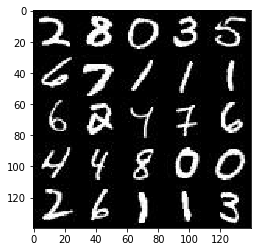

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

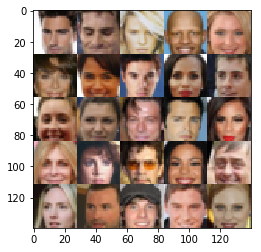

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.10.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, (None))
    return inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(inputs=relu1, rate=dropout, training=False)   
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(inputs=relu2, rate=dropout, training=False)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(inputs=relu3, rate=dropout, training=False)
        # 4x4x256

        # Flatten it
#         flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, dropout=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 3*3*512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512

        h11 = tf.layers.conv2d_transpose(h1, 512, 
                                        kernel_size=4, 
                                        strides=1, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h11 = tf.layers.batch_normalization(h11, training=is_train)
        h11 = tf.maximum(alpha * h11, h11)
        h11 = tf.layers.dropout(inputs=h11, rate=dropout, training=is_train)
        
        print(tf.shape(h11))
        # 4x4x256        
        
        h2 = tf.layers.conv2d_transpose(h11, 256, 
                                        kernel_size=4, 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.layers.dropout(inputs=h2, rate=dropout, training=is_train)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 
                                        kernel_size=4, 
                                        strides=2, 
                                        padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.layers.dropout(inputs=h3, rate=dropout, training=is_train)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 
                                            kernel_size=5, 
                                            strides=2, 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        # 28x28x5
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("Shape_1:0", shape=(4,), dtype=int32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=False)
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=True)
    
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/Shape:0", shape=(4,), dtype=int32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [ ]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 10
    show_step = 100
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting the training")    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                for i in range(2):
                    _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    
    print("Finished the training")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("generator/Shape:0", shape=(4,), dtype=int32)
Starting the training
Step: 10: Epoch 1/2... Discriminator Loss: 2.8277... Generator Loss: 0.3326
Step: 20: Epoch 1/2... Discriminator Loss: 2.3738... Generator Loss: 1.3187
Step: 30: Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 1.4857
Step: 40: Epoch 1/2... Discriminator Loss: 2.5347... Generator Loss: 0.6676
Step: 50: Epoch 1/2... Discriminator Loss: 1.8350... Generator Loss: 2.5541
Step: 60: Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 1.9814
Step: 70: Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 3.2964
Step: 80: Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.8653
Step: 90: Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 1.4094
Step: 100: Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.6339
Tensor("generator_1/Shape:0", shape=(4,), dtype=int32)


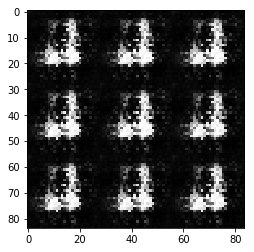

Step: 110: Epoch 1/2... Discriminator Loss: 2.5827... Generator Loss: 0.1749
Step: 120: Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.5903
Step: 130: Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.8410
Step: 140: Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.9819
Step: 150: Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.9380
Step: 160: Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.5352
Step: 170: Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 1.0236
Step: 180: Epoch 1/2... Discriminator Loss: 2.1438... Generator Loss: 0.5909
Step: 190: Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.6358
Step: 200: Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.5059
Tensor("generator_2/Shape:0", shape=(4,), dtype=int32)


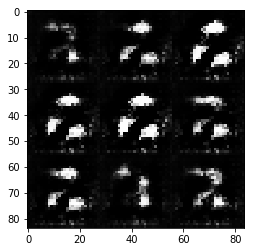

Step: 210: Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 0.5010
Step: 220: Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.8402
Step: 230: Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 0.6296
Step: 240: Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.6545
Step: 250: Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.5536
Step: 260: Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.8832
Step: 270: Epoch 1/2... Discriminator Loss: 1.5198... Generator Loss: 0.5583
Step: 280: Epoch 1/2... Discriminator Loss: 1.7425... Generator Loss: 0.3963
Step: 290: Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 0.9913
Step: 300: Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.6999
Tensor("generator_3/Shape:0", shape=(4,), dtype=int32)


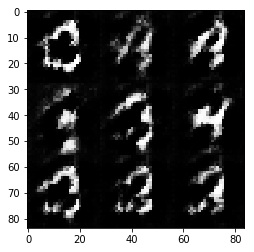

Step: 310: Epoch 1/2... Discriminator Loss: 1.8975... Generator Loss: 0.3408
Step: 320: Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.5638
Step: 330: Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 0.9850
Step: 340: Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 0.8466
Step: 350: Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.9827
Step: 360: Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.6898
Step: 370: Epoch 1/2... Discriminator Loss: 1.6017... Generator Loss: 0.5106
Step: 380: Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 1.2557
Step: 390: Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 1.2563
Step: 400: Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 1.0876
Tensor("generator_4/Shape:0", shape=(4,), dtype=int32)


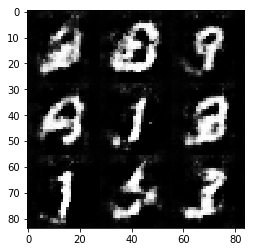

Step: 410: Epoch 1/2... Discriminator Loss: 1.8445... Generator Loss: 0.3250
Step: 420: Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 1.1392
Step: 430: Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.8842
Step: 440: Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.8137
Step: 450: Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6883
Step: 460: Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.7561
Step: 470: Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.5747
Step: 480: Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4710
Step: 490: Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.4980
Step: 500: Epoch 1/2... Discriminator Loss: 1.6217... Generator Loss: 0.4598
Tensor("generator_5/Shape:0", shape=(4,), dtype=int32)


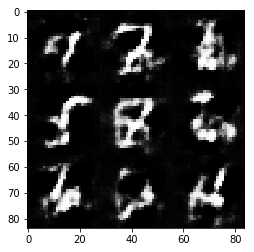

Step: 510: Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 1.0980
Step: 520: Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.5743
Step: 530: Epoch 1/2... Discriminator Loss: 1.4977... Generator Loss: 0.9836
Step: 540: Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.8889
Step: 550: Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.8940
Step: 560: Epoch 1/2... Discriminator Loss: 1.8046... Generator Loss: 0.2845
Step: 570: Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.5575
Step: 580: Epoch 1/2... Discriminator Loss: 1.5897... Generator Loss: 0.4057
Step: 590: Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.5968
Step: 600: Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 1.2413
Tensor("generator_6/Shape:0", shape=(4,), dtype=int32)


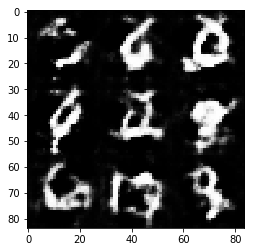

Step: 610: Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 0.4377
Step: 620: Epoch 1/2... Discriminator Loss: 1.5935... Generator Loss: 0.4046
Step: 630: Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5474
Step: 640: Epoch 1/2... Discriminator Loss: 1.5339... Generator Loss: 0.3856
Step: 650: Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.7647
Step: 660: Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.9999
Step: 670: Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.8482
Step: 680: Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.6622
Step: 690: Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.5283
Step: 700: Epoch 1/2... Discriminator Loss: 1.7260... Generator Loss: 0.3566
Tensor("generator_7/Shape:0", shape=(4,), dtype=int32)


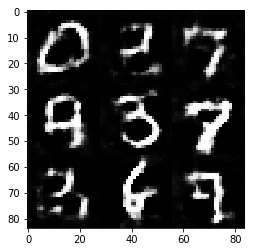

Step: 710: Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.5129
Step: 720: Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.4726
Step: 730: Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.8822
Step: 740: Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.5923
Step: 750: Epoch 1/2... Discriminator Loss: 1.7352... Generator Loss: 1.4960
Step: 760: Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.7806
Step: 770: Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.5496
Step: 780: Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.6816
Step: 790: Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 1.1854
Step: 800: Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.6672
Tensor("generator_8/Shape:0", shape=(4,), dtype=int32)


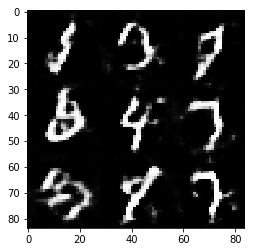

Step: 810: Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 1.1627
Step: 820: Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.8983
Step: 830: Epoch 1/2... Discriminator Loss: 1.5153... Generator Loss: 0.4610
Step: 840: Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.6387
Step: 850: Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.4709
Step: 860: Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.4884
Step: 870: Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.4884
Step: 880: Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.7196
Step: 890: Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.9488
Step: 900: Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 1.4176
Tensor("generator_9/Shape:0", shape=(4,), dtype=int32)


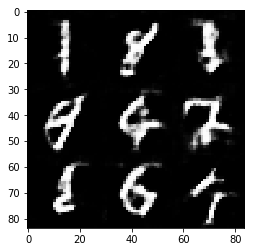

Step: 910: Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.8056
Step: 920: Epoch 1/2... Discriminator Loss: 1.5987... Generator Loss: 1.2635
Step: 930: Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.7826
Step: 940: Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.6808
Step: 950: Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.9281
Step: 960: Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.5651
Step: 970: Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 1.1830
Step: 980: Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.8845
Step: 990: Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.9321
Step: 1000: Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.8861
Tensor("generator_10/Shape:0", shape=(4,), dtype=int32)


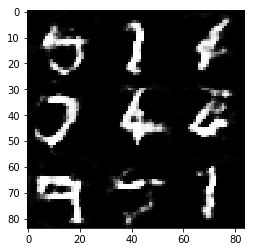

Step: 1010: Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.7875
Step: 1020: Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 1.0214
Step: 1030: Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 1.2581
Step: 1040: Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.5229
Step: 1050: Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.6533
Step: 1060: Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 1.2602
Step: 1070: Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.6683
Step: 1080: Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.8576
Step: 1090: Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.4442
Step: 1100: Epoch 1/2... Discriminator Loss: 1.5434... Generator Loss: 0.4027
Tensor("generator_11/Shape:0", shape=(4,), dtype=int32)


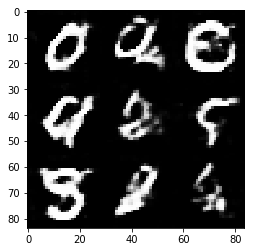

Step: 1110: Epoch 1/2... Discriminator Loss: 1.7668... Generator Loss: 0.3024
Step: 1120: Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.5833
Step: 1130: Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.4690
Step: 1140: Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.8241
Step: 1150: Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 0.3748
Step: 1160: Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.6358
Step: 1170: Epoch 1/2... Discriminator Loss: 1.5765... Generator Loss: 0.4633
Step: 1180: Epoch 1/2... Discriminator Loss: 1.7946... Generator Loss: 0.2858
Step: 1190: Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.5759
Step: 1200: Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.4172
Tensor("generator_12/Shape:0", shape=(4,), dtype=int32)


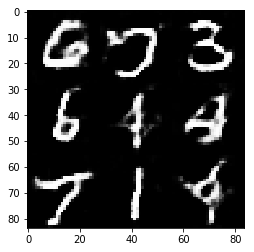

Step: 1210: Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.6782
Step: 1220: Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.7161
Step: 1230: Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.5400
Step: 1240: Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.6560
Step: 1250: Epoch 1/2... Discriminator Loss: 1.7266... Generator Loss: 0.3432
Step: 1260: Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.7968
Step: 1270: Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 1.1821
Step: 1280: Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.6331
Step: 1290: Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 1.3528
Step: 1300: Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 1.1656
Tensor("generator_13/Shape:0", shape=(4,), dtype=int32)


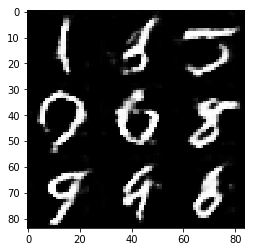

Step: 1310: Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.6901
Step: 1320: Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.5354
Step: 1330: Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 1.5845
Step: 1340: Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.6215
Step: 1350: Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 1.0419
Step: 1360: Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.8144
Step: 1370: Epoch 1/2... Discriminator Loss: 1.6354... Generator Loss: 0.3773
Step: 1380: Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 1.1318
Step: 1390: Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.7809
Step: 1400: Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 1.0418
Tensor("generator_14/Shape:0", shape=(4,), dtype=int32)


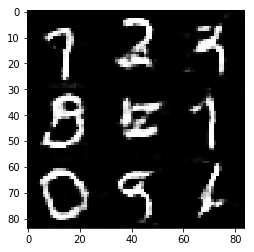

Step: 1410: Epoch 1/2... Discriminator Loss: 1.5406... Generator Loss: 0.5980
Step: 1420: Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.8135
Step: 1430: Epoch 1/2... Discriminator Loss: 1.9776... Generator Loss: 1.9364
Step: 1440: Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.7655
Step: 1450: Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.6640
Step: 1460: Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 1.0953
Step: 1470: Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 1.4024
Step: 1480: Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.0915
Step: 1490: Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.3653
Step: 1500: Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.4969
Tensor("generator_15/Shape:0", shape=(4,), dtype=int32)


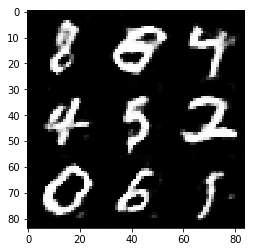

Step: 1510: Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.4926
Step: 1520: Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.5381
Step: 1530: Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.7043
Step: 1540: Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 1.0429
Step: 1550: Epoch 1/2... Discriminator Loss: 1.7594... Generator Loss: 2.1677
Step: 1560: Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.6165
Step: 1570: Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.5198
Step: 1580: Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 0.4887
Step: 1590: Epoch 1/2... Discriminator Loss: 1.2018... Generator Loss: 0.6568
Step: 1600: Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 1.4745
Tensor("generator_16/Shape:0", shape=(4,), dtype=int32)


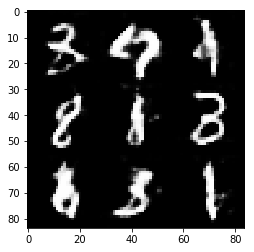

Step: 1610: Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.9091
Step: 1620: Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.6299
Step: 1630: Epoch 1/2... Discriminator Loss: 1.7005... Generator Loss: 1.8872
Step: 1640: Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.7750
Step: 1650: Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 1.0231
Step: 1660: Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 0.9355
Step: 1670: Epoch 1/2... Discriminator Loss: 2.0162... Generator Loss: 0.2522
Step: 1680: Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.5642
Step: 1690: Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.5955
Step: 1700: Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.5476
Tensor("generator_17/Shape:0", shape=(4,), dtype=int32)


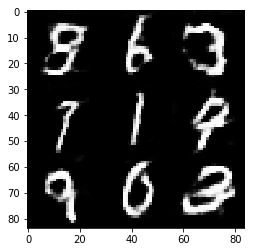

Step: 1710: Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 0.3967
Step: 1720: Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.0440
Step: 1730: Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 1.0461
Step: 1740: Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 1.1281
Step: 1750: Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 1.1077
Step: 1760: Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.7630
Step: 1770: Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.1522
Step: 1780: Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.8646
Step: 1790: Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 1.1313
Step: 1800: Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.6895
Tensor("generator_18/Shape:0", shape=(4,), dtype=int32)


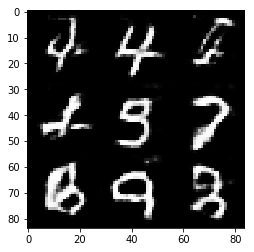

Step: 1810: Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.5755
Step: 1820: Epoch 1/2... Discriminator Loss: 2.1807... Generator Loss: 0.2291
Step: 1830: Epoch 1/2... Discriminator Loss: 1.6530... Generator Loss: 0.3620
Step: 1840: Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.1444
Step: 1850: Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.8400
Step: 1860: Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.6513
Step: 1870: Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.6977
Step: 1880: Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.9214
Step: 1890: Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.8886
Step: 1900: Epoch 2/2... Discriminator Loss: 1.6778... Generator Loss: 2.2173
Tensor("generator_19/Shape:0", shape=(4,), dtype=int32)


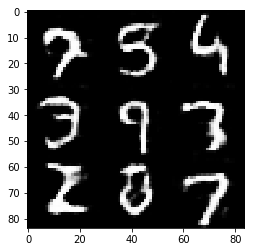

Step: 1910: Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 1.0938
Step: 1920: Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 1.2807
Step: 1930: Epoch 2/2... Discriminator Loss: 1.8916... Generator Loss: 2.1093
Step: 1940: Epoch 2/2... Discriminator Loss: 1.1569... Generator Loss: 0.9108
Step: 1950: Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 1.0143
Step: 1960: Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.7016
Step: 1970: Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.2325
Step: 1980: Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.5585
Step: 1990: Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 1.4098
Step: 2000: Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 1.6952
Tensor("generator_20/Shape:0", shape=(4,), dtype=int32)


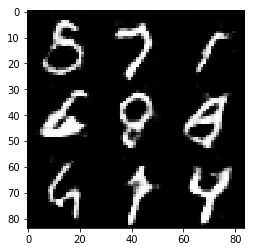

Step: 2010: Epoch 2/2... Discriminator Loss: 1.6899... Generator Loss: 1.9617
Step: 2020: Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.8494
Step: 2030: Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.8491
Step: 2040: Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.4621
Step: 2050: Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.6378
Step: 2060: Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.8339
Step: 2070: Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.9678
Step: 2080: Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.9770
Step: 2090: Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.7631
Step: 2100: Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.6429
Tensor("generator_21/Shape:0", shape=(4,), dtype=int32)


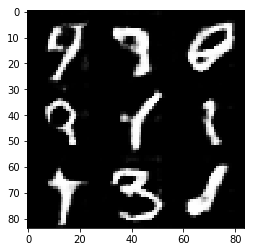

Step: 2110: Epoch 2/2... Discriminator Loss: 2.3184... Generator Loss: 0.1764
Step: 2120: Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 0.6829
Step: 2130: Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.7104
Step: 2140: Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4939
Step: 2150: Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.1222
Step: 2160: Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.7430
Step: 2170: Epoch 2/2... Discriminator Loss: 1.4688... Generator Loss: 2.0488
Step: 2180: Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 1.4559
Step: 2190: Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.5369
Step: 2200: Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 1.4611
Tensor("generator_22/Shape:0", shape=(4,), dtype=int32)


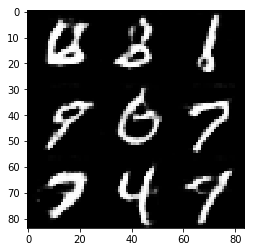

Step: 2210: Epoch 2/2... Discriminator Loss: 1.6571... Generator Loss: 0.3899
Step: 2220: Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.6519
Step: 2230: Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.3659
Step: 2240: Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.2041
Step: 2250: Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 1.9672
Step: 2260: Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.1753
Step: 2270: Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 1.4246
Step: 2280: Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.1362
Step: 2290: Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.2250
Step: 2300: Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.6297
Tensor("generator_23/Shape:0", shape=(4,), dtype=int32)


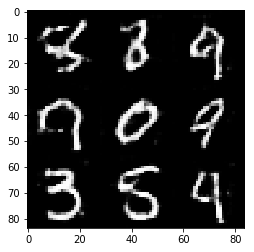

Step: 2310: Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.5834
Step: 2320: Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 1.0089
Step: 2330: Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.1092
Step: 2340: Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.0265
Step: 2350: Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.7621
Step: 2360: Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 0.9964
Step: 2370: Epoch 2/2... Discriminator Loss: 2.3065... Generator Loss: 0.1988
Step: 2380: Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.8725
Step: 2390: Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.7969
Step: 2400: Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 0.7376
Tensor("generator_24/Shape:0", shape=(4,), dtype=int32)


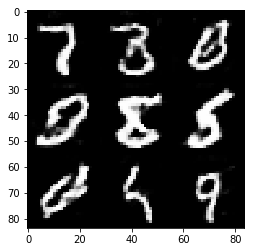

Step: 2410: Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 1.0928
Step: 2420: Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.5909
Step: 2430: Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 1.3509
Step: 2440: Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 1.2882
Step: 2450: Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.8201
Step: 2460: Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 1.2733
Step: 2470: Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.6795
Step: 2480: Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.6449
Step: 2490: Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.4443
Step: 2500: Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 1.2965
Tensor("generator_25/Shape:0", shape=(4,), dtype=int32)


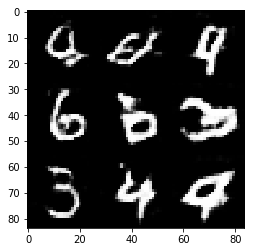

Step: 2510: Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.9313
Step: 2520: Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.8085
Step: 2530: Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.7124
Step: 2540: Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.5477
Step: 2550: Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.6833
Step: 2560: Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.8380
Step: 2570: Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.5384
Step: 2580: Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.2834
Step: 2590: Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.0412
Step: 2600: Epoch 2/2... Discriminator Loss: 3.7449... Generator Loss: 0.0673
Tensor("generator_26/Shape:0", shape=(4,), dtype=int32)


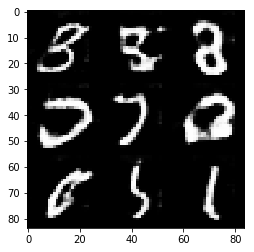

Step: 2610: Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.0736
Step: 2620: Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.7520
Step: 2630: Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.3737
Step: 2640: Epoch 2/2... Discriminator Loss: 2.2560... Generator Loss: 0.2587
Step: 2650: Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.1528
Step: 2660: Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.2292
Step: 2670: Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.0300
Step: 2680: Epoch 2/2... Discriminator Loss: 1.9774... Generator Loss: 2.3381
Step: 2690: Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.6854
Step: 2700: Epoch 2/2... Discriminator Loss: 0.8669... Generator Loss: 1.1523
Tensor("generator_27/Shape:0", shape=(4,), dtype=int32)


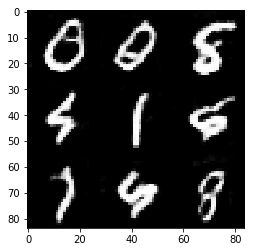

Step: 2710: Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 1.5730
Step: 2720: Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 1.2211
Step: 2730: Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 1.8735
Step: 2740: Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 2.0156
Step: 2750: Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 0.5279
Step: 2760: Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.8414
Step: 2770: Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.5688
Step: 2780: Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.4211
Step: 2790: Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.7770
Step: 2800: Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 0.7646
Tensor("generator_28/Shape:0", shape=(4,), dtype=int32)


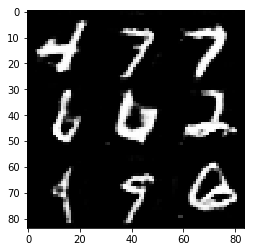

Step: 2810: Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 1.2694
Step: 2820: Epoch 2/2... Discriminator Loss: 1.6862... Generator Loss: 0.4245
Step: 2830: Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.5232
Step: 2840: Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 1.5020
Step: 2850: Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.6665
Step: 2860: Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 1.7580
Step: 2870: Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.9142
Step: 2880: Epoch 2/2... Discriminator Loss: 1.6872... Generator Loss: 0.3697
Step: 2890: Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.1771
Step: 2900: Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.6847
Tensor("generator_29/Shape:0", shape=(4,), dtype=int32)


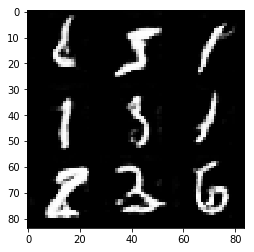

Step: 2910: Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.5291
Step: 2920: Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.4688
Step: 2930: Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.9858
Step: 2940: Epoch 2/2... Discriminator Loss: 1.4092... Generator Loss: 0.5907
Step: 2950: Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 1.1477
Step: 2960: Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.5824
Step: 2970: Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.2840
Step: 2980: Epoch 2/2... Discriminator Loss: 0.7505... Generator Loss: 1.0098
Step: 2990: Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 1.0870
Step: 3000: Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.0734
Tensor("generator_30/Shape:0", shape=(4,), dtype=int32)


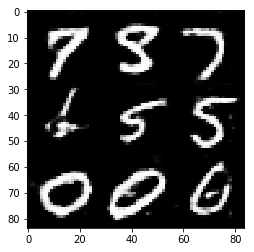

Step: 3010: Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.4135
Step: 3020: Epoch 2/2... Discriminator Loss: 1.9844... Generator Loss: 0.2564
Step: 3030: Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.6038
Step: 3040: Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 0.8783
Step: 3050: Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.1559
Step: 3060: Epoch 2/2... Discriminator Loss: 1.7838... Generator Loss: 0.3020
Step: 3070: Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 1.0448
Step: 3080: Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 0.5701
Step: 3090: Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.5917
Step: 3100: Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.5711
Tensor("generator_31/Shape:0", shape=(4,), dtype=int32)


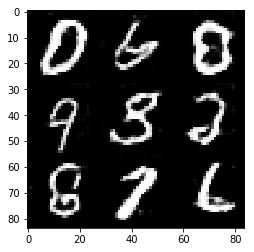

Step: 3110: Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 0.8813
Step: 3120: Epoch 2/2... Discriminator Loss: 1.7807... Generator Loss: 0.2575
Step: 3130: Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.6866
Step: 3140: Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.4668
Step: 3150: Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.7672
Step: 3160: Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 0.9779
Step: 3170: Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 0.9412
Step: 3180: Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 1.4036
Step: 3190: Epoch 2/2... Discriminator Loss: 1.8101... Generator Loss: 0.2984
Step: 3200: Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.3686
Tensor("generator_32/Shape:0", shape=(4,), dtype=int32)


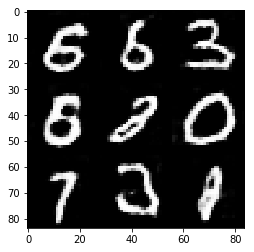

Step: 3210: Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.7502
Step: 3220: Epoch 2/2... Discriminator Loss: 1.5184... Generator Loss: 0.4307
Step: 3230: Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 0.8422
Step: 3240: Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 1.0716
Step: 3250: Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 2.1044
Step: 3260: Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 0.8449
Step: 3270: Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 0.7619
Step: 3280: Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.0503
Step: 3290: Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.9728
Step: 3300: Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 0.6995
Tensor("generator_33/Shape:0", shape=(4,), dtype=int32)


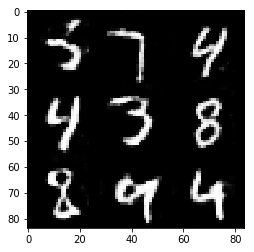

Step: 3310: Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.0238
Step: 3320: Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.2342
Step: 3330: Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.6799
Step: 3340: Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 1.2242
Step: 3350: Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.2495
Step: 3360: Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.6404
Step: 3370: Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.0925
Step: 3380: Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 1.8121
Step: 3390: Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.7683
Step: 3400: Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.6607
Tensor("generator_34/Shape:0", shape=(4,), dtype=int32)


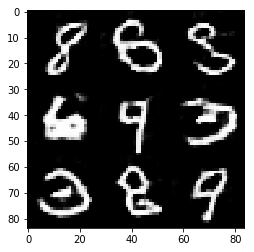

Step: 3410: Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.1755
Step: 3420: Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 0.6357
Step: 3430: Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.9468
Step: 3440: Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.5608
Step: 3450: Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.7213
Step: 3460: Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.8370
Step: 3470: Epoch 2/2... Discriminator Loss: 0.7355... Generator Loss: 1.1936
Step: 3480: Epoch 2/2... Discriminator Loss: 1.4679... Generator Loss: 0.4921
Step: 3490: Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.3932
Step: 3500: Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.1235
Tensor("generator_35/Shape:0", shape=(4,), dtype=int32)


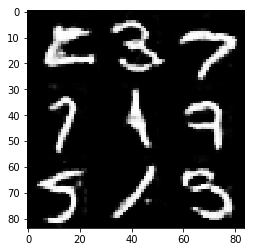

Step: 3510: Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.4608
Step: 3520: Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.1719
Step: 3530: Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 0.8608
Step: 3540: Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.5248
Step: 3550: Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.6805
Step: 3560: Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 1.3884
Step: 3570: Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.1809
Step: 3580: Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.0215
Step: 3590: Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 0.9283
Step: 3600: Epoch 2/2... Discriminator Loss: 0.7094... Generator Loss: 1.1471
Tensor("generator_36/Shape:0", shape=(4,), dtype=int32)


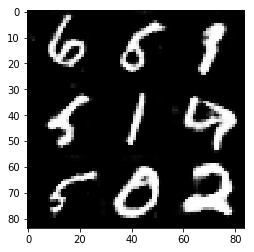

Step: 3610: Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 2.2306
Step: 3620: Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.9067
Step: 3630: Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 2.2514
Step: 3640: Epoch 2/2... Discriminator Loss: 0.7276... Generator Loss: 1.3358
Step: 3650: Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.1362
Step: 3660: Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.8187
Step: 3670: Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.2659
Step: 3680: Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.2867
Step: 3690: Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 1.2923
Step: 3700: Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 1.8632
Tensor("generator_37/Shape:0", shape=(4,), dtype=int32)


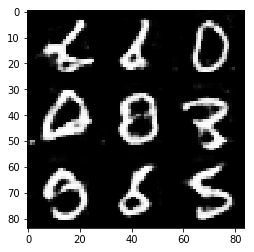

Step: 3710: Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.5247
Step: 3720: Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.6782
Step: 3730: Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.6133
Step: 3740: Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 0.9819
Step: 3750: Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 0.9593
Finished the training


In [44]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("generator/Shape:0", shape=(4,), dtype=int32)
Starting the training
Step: 10: Epoch 1/1... Discriminator Loss: 2.2119... Generator Loss: 0.6968
Step: 20: Epoch 1/1... Discriminator Loss: 1.7624... Generator Loss: 2.4767
Step: 30: Epoch 1/1... Discriminator Loss: 2.0023... Generator Loss: 3.3078
Step: 40: Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 3.2899
Step: 50: Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 1.9930
Step: 60: Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 2.7613
Step: 70: Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6804
Step: 80: Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.3696
Step: 90: Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 2.1402
Step: 100: Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.9260
Tensor("generator_1/Shape:0", shape=(4,), dtype=int32)


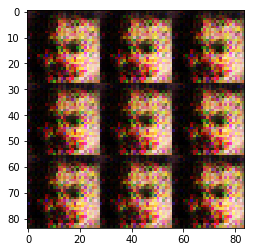

Step: 110: Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 2.2050
Step: 120: Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.7271
Step: 130: Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 2.4940
Step: 140: Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 2.3264
Step: 150: Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 2.4330
Step: 160: Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.5131
Step: 170: Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 2.4589
Step: 180: Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5804
Step: 190: Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.2513
Step: 200: Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 1.2602
Tensor("generator_2/Shape:0", shape=(4,), dtype=int32)


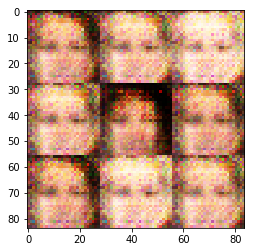

Step: 210: Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 1.2820
Step: 220: Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8653
Step: 230: Epoch 1/1... Discriminator Loss: 1.6766... Generator Loss: 1.4854
Step: 240: Epoch 1/1... Discriminator Loss: 2.2991... Generator Loss: 0.2815
Step: 250: Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.5845
Step: 260: Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6120
Step: 270: Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6110
Step: 280: Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.5510
Step: 290: Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.5070
Step: 300: Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.9748
Tensor("generator_3/Shape:0", shape=(4,), dtype=int32)


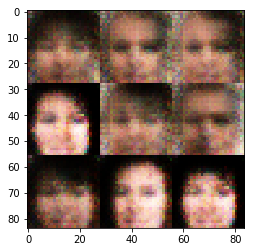

Step: 310: Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7175
Step: 320: Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 1.0622
Step: 330: Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7684
Step: 340: Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 1.0441
Step: 350: Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.6518
Step: 360: Epoch 1/1... Discriminator Loss: 1.8194... Generator Loss: 0.4055
Step: 370: Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.4865
Step: 380: Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.5252
Step: 390: Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6905
Step: 400: Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7265
Tensor("generator_4/Shape:0", shape=(4,), dtype=int32)


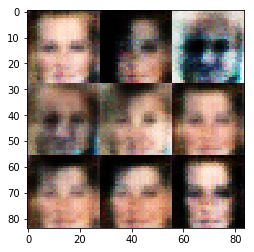

Step: 410: Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.6244
Step: 420: Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8451
Step: 430: Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5784
Step: 440: Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.5875
Step: 450: Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.9526
Step: 460: Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5937
Step: 470: Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6009
Step: 480: Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5537
Step: 490: Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.7858
Step: 500: Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.4524
Tensor("generator_5/Shape:0", shape=(4,), dtype=int32)


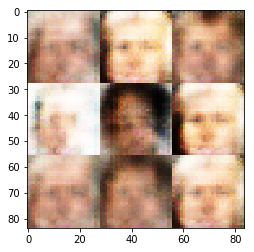

Step: 510: Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5619
Step: 520: Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.7143
Step: 530: Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.8743
Step: 540: Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6580
Step: 550: Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 1.0091
Step: 560: Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6589
Step: 570: Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.5987
Step: 580: Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.6771
Step: 590: Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6658
Step: 600: Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7504
Tensor("generator_6/Shape:0", shape=(4,), dtype=int32)


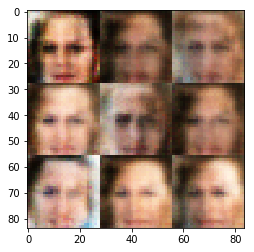

Step: 610: Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7572
Step: 620: Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5748
Step: 630: Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.9620
Step: 640: Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6688
Step: 650: Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5362
Step: 660: Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7420
Step: 670: Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.6159
Step: 680: Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7284
Step: 690: Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.7530
Step: 700: Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7566
Tensor("generator_7/Shape:0", shape=(4,), dtype=int32)


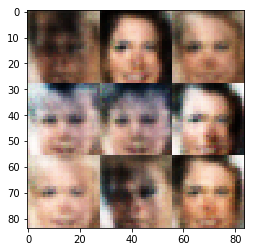

Step: 710: Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8378
Step: 720: Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7014
Step: 730: Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7431
Step: 740: Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7288
Step: 750: Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7965
Step: 760: Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6114
Step: 770: Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7547
Step: 780: Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6981
Step: 790: Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6557
Step: 800: Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.7289
Tensor("generator_8/Shape:0", shape=(4,), dtype=int32)


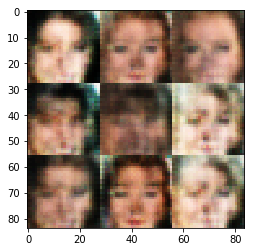

Step: 810: Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7977
Step: 820: Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6652
Step: 830: Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8020
Step: 840: Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6707
Step: 850: Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.8965
Step: 860: Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.8086
Step: 870: Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7641
Step: 880: Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7389
Step: 890: Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6901
Step: 900: Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6552
Tensor("generator_9/Shape:0", shape=(4,), dtype=int32)


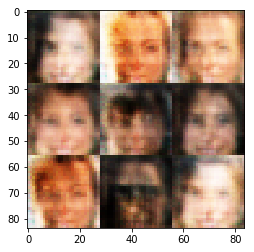

Step: 910: Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8369
Step: 920: Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7646
Step: 930: Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8375
Step: 940: Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7749
Step: 950: Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7329
Step: 960: Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.8942
Step: 970: Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6926
Step: 980: Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6576
Step: 990: Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6622
Step: 1000: Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7102
Tensor("generator_10/Shape:0", shape=(4,), dtype=int32)


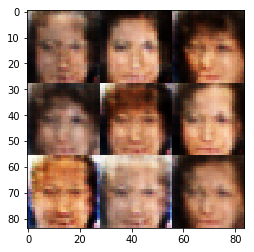

Step: 1010: Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7364
Step: 1020: Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.7565
Step: 1030: Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7775
Step: 1040: Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6799
Step: 1050: Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7207
Step: 1060: Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8057
Step: 1070: Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7023
Step: 1080: Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7423
Step: 1090: Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.6272
Step: 1100: Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7668
Tensor("generator_11/Shape:0", shape=(4,), dtype=int32)


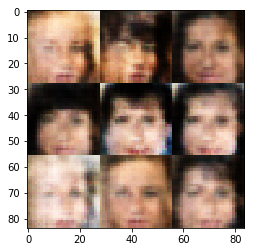

Step: 1110: Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7944
Step: 1120: Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.8177
Step: 1130: Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7073
Step: 1140: Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6394
Step: 1150: Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6647
Step: 1160: Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7893
Step: 1170: Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7506
Step: 1180: Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7390
Step: 1190: Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7504
Step: 1200: Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6907
Tensor("generator_12/Shape:0", shape=(4,), dtype=int32)


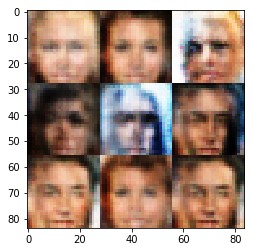

Step: 1210: Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.7036
Step: 1220: Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6875
Step: 1230: Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6866
Step: 1240: Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7062
Step: 1250: Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6870
Step: 1260: Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7468
Step: 1270: Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.7395
Step: 1280: Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7637
Step: 1290: Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8256
Step: 1300: Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7770
Tensor("generator_13/Shape:0", shape=(4,), dtype=int32)


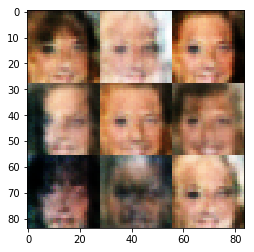

Step: 1310: Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8103
Step: 1320: Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7855
Step: 1330: Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7218
Step: 1340: Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7787
Step: 1350: Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6968
Step: 1360: Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6158
Step: 1370: Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7533
Step: 1380: Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7657
Step: 1390: Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6524
Step: 1400: Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6565
Tensor("generator_14/Shape:0", shape=(4,), dtype=int32)


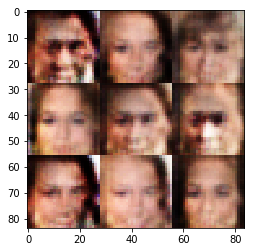

Step: 1410: Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.8192
Step: 1420: Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6907
Step: 1430: Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7793
Step: 1440: Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6504
Step: 1450: Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7503
Step: 1460: Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7143
Step: 1470: Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7375
Step: 1480: Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7245
Step: 1490: Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8044
Step: 1500: Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7451
Tensor("generator_15/Shape:0", shape=(4,), dtype=int32)


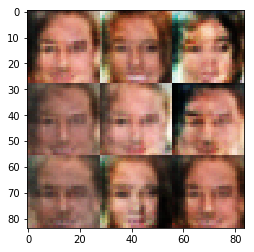

Step: 1510: Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7138
Step: 1520: Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7264
Step: 1530: Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6714
Step: 1540: Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7673
Step: 1550: Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7442
Step: 1560: Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8036
Step: 1570: Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7671
Step: 1580: Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6975
Step: 1590: Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7387
Step: 1600: Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6574
Tensor("generator_16/Shape:0", shape=(4,), dtype=int32)


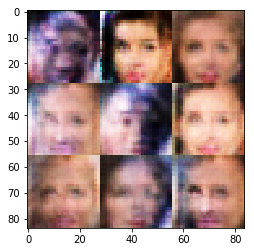

Step: 1610: Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7201
Step: 1620: Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7076
Step: 1630: Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7815
Step: 1640: Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7099
Step: 1650: Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7238
Step: 1660: Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7637
Step: 1670: Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7399
Step: 1680: Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6976
Step: 1690: Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6975
Step: 1700: Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7789
Tensor("generator_17/Shape:0", shape=(4,), dtype=int32)


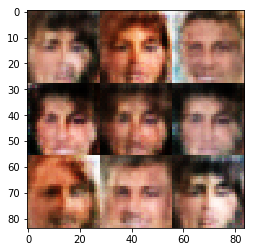

Step: 1710: Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7265
Step: 1720: Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7032
Step: 1730: Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8411
Step: 1740: Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7618
Step: 1750: Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7059
Step: 1760: Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8388
Step: 1770: Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.6884
Step: 1780: Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7490
Step: 1790: Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6930
Step: 1800: Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7467
Tensor("generator_18/Shape:0", shape=(4,), dtype=int32)


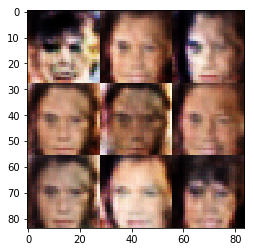

Step: 1810: Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8035
Step: 1820: Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7875
Step: 1830: Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7474
Step: 1840: Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8508
Step: 1850: Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7959
Step: 1860: Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7925
Step: 1870: Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7011
Step: 1880: Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6715
Step: 1890: Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7590
Step: 1900: Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7310
Tensor("generator_19/Shape:0", shape=(4,), dtype=int32)


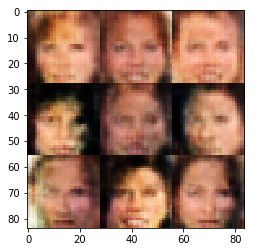

Step: 1910: Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7608
Step: 1920: Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7232
Step: 1930: Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.7615
Step: 1940: Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7085
Step: 1950: Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7555
Step: 1960: Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7538
Step: 1970: Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7042
Step: 1980: Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7662
Step: 1990: Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6958
Step: 2000: Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7414
Tensor("generator_20/Shape:0", shape=(4,), dtype=int32)


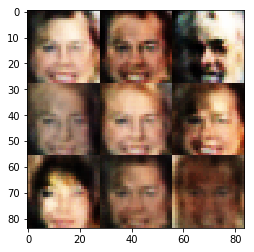

Step: 2010: Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7683
Step: 2020: Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8004
Step: 2030: Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7233
Step: 2040: Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7549
Step: 2050: Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7539
Step: 2060: Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7946
Step: 2070: Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7284
Step: 2080: Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7720
Step: 2090: Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7268
Step: 2100: Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7638
Tensor("generator_21/Shape:0", shape=(4,), dtype=int32)


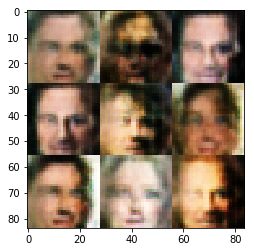

Step: 2110: Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7034
Step: 2120: Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7110
Step: 2130: Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7517
Step: 2140: Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7470
Step: 2150: Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7706
Step: 2160: Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6553
Step: 2170: Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7029
Step: 2180: Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6994
Step: 2190: Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8272
Step: 2200: Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7062
Tensor("generator_22/Shape:0", shape=(4,), dtype=int32)


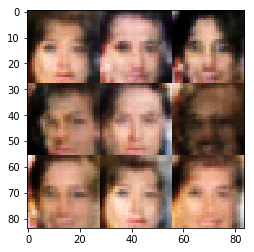

Step: 2210: Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7472
Step: 2220: Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7386
Step: 2230: Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7610
Step: 2240: Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6867
Step: 2250: Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7525
Step: 2260: Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7075
Step: 2270: Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7620
Step: 2280: Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7270
Step: 2290: Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7445
Step: 2300: Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7618
Tensor("generator_23/Shape:0", shape=(4,), dtype=int32)


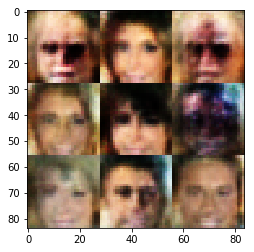

Step: 2310: Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7209
Step: 2320: Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7736
Step: 2330: Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7711
Step: 2340: Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7436
Step: 2350: Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7069
Step: 2360: Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8000
Step: 2370: Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7470
Step: 2380: Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7670
Step: 2390: Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8238
Step: 2400: Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7582
Tensor("generator_24/Shape:0", shape=(4,), dtype=int32)


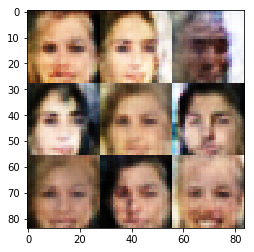

Step: 2410: Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7596
Step: 2420: Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8101
Step: 2430: Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7258
Step: 2440: Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7420
Step: 2450: Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7628
Step: 2460: Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7782
Step: 2470: Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8867
Step: 2480: Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7255
Step: 2490: Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7603
Step: 2500: Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7393
Tensor("generator_25/Shape:0", shape=(4,), dtype=int32)


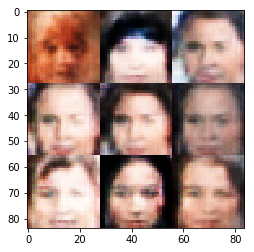

Step: 2510: Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7996
Step: 2520: Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7184
Step: 2530: Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6524
Step: 2540: Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7886
Step: 2550: Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7138
Step: 2560: Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6764
Step: 2570: Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7334
Step: 2580: Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7698
Step: 2590: Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7542
Step: 2600: Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7123
Tensor("generator_26/Shape:0", shape=(4,), dtype=int32)


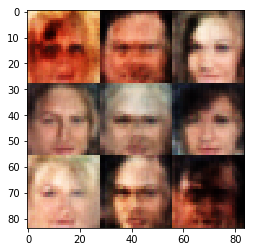

Step: 2610: Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7627
Step: 2620: Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6724
Step: 2630: Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7349
Step: 2640: Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6956
Step: 2650: Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7286
Step: 2660: Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8150
Step: 2670: Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7194
Step: 2680: Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8240
Step: 2690: Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7128
Step: 2700: Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7593
Tensor("generator_27/Shape:0", shape=(4,), dtype=int32)


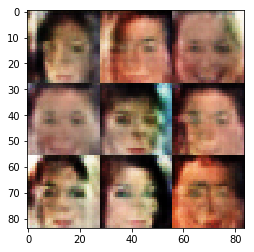

Step: 2710: Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7129
Step: 2720: Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6892
Step: 2730: Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7733
Step: 2740: Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7145
Step: 2750: Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7696
Step: 2760: Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8232
Step: 2770: Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7302
Step: 2780: Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7205
Step: 2790: Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.7537
Step: 2800: Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8078
Tensor("generator_28/Shape:0", shape=(4,), dtype=int32)


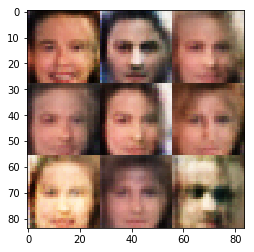

Step: 2810: Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7192
Step: 2820: Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7398
Step: 2830: Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7319
Step: 2840: Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7022
Step: 2850: Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8341
Step: 2860: Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7295
Step: 2870: Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7482
Step: 2880: Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7267
Step: 2890: Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7190
Step: 2900: Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7174
Tensor("generator_29/Shape:0", shape=(4,), dtype=int32)


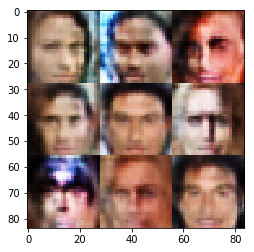

Step: 2910: Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7583
Step: 2920: Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7385
Step: 2930: Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7059
Step: 2940: Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7155
Step: 2950: Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7942
Step: 2960: Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7449
Step: 2970: Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7383
Step: 2980: Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7568
Step: 2990: Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7677
Step: 3000: Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7615
Tensor("generator_30/Shape:0", shape=(4,), dtype=int32)


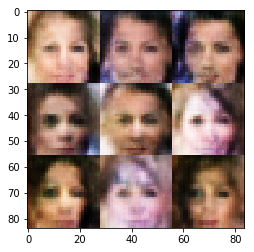

Step: 3010: Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7031
Step: 3020: Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7312
Step: 3030: Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7289
Step: 3040: Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8069
Step: 3050: Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7154
Step: 3060: Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7707
Step: 3070: Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7641
Step: 3080: Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7028
Step: 3090: Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7512
Step: 3100: Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7980
Tensor("generator_31/Shape:0", shape=(4,), dtype=int32)


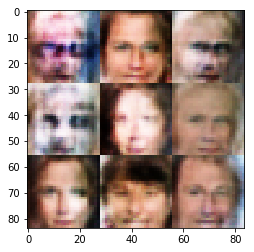

Step: 3110: Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7516
Step: 3120: Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8711
Step: 3130: Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7160
Step: 3140: Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7393
Step: 3150: Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7797
Step: 3160: Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7762
Step: 3170: Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7004
Step: 3180: Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7993
Step: 3190: Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7160
Step: 3200: Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7609
Tensor("generator_32/Shape:0", shape=(4,), dtype=int32)


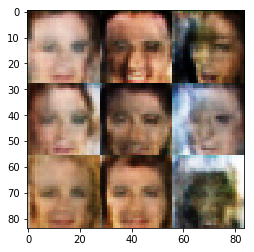

Step: 3210: Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7699
Step: 3220: Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7237
Step: 3230: Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7496
Step: 3240: Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7506
Step: 3250: Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7944
Step: 3260: Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7997
Step: 3270: Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.6705
Step: 3280: Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7971
Step: 3290: Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7464
Step: 3300: Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7042
Tensor("generator_33/Shape:0", shape=(4,), dtype=int32)


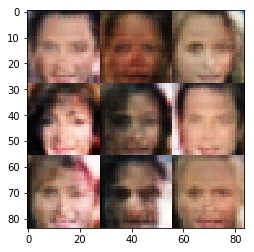

Step: 3310: Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7025
Step: 3320: Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7060
Step: 3330: Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8097
Step: 3340: Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6951
Step: 3350: Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7249
Step: 3360: Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7959
Step: 3370: Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7635
Step: 3380: Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7085
Step: 3390: Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7728
Step: 3400: Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7364
Tensor("generator_34/Shape:0", shape=(4,), dtype=int32)


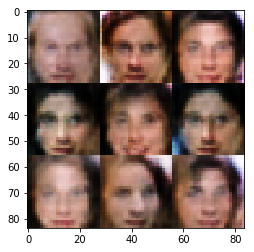

Step: 3410: Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7729
Step: 3420: Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8141
Step: 3430: Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7699
Step: 3440: Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7193
Step: 3450: Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6611
Step: 3460: Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7748
Step: 3470: Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7609
Step: 3480: Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7689
Step: 3490: Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7295
Step: 3500: Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7763
Tensor("generator_35/Shape:0", shape=(4,), dtype=int32)


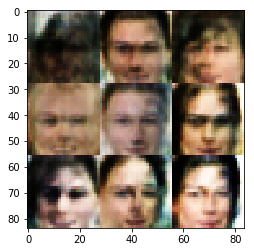

Step: 3510: Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7387
Step: 3520: Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6792
Step: 3530: Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7872
Step: 3540: Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7554
Step: 3550: Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6910
Step: 3560: Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7657
Step: 3570: Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7645
Step: 3580: Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7495
Step: 3590: Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7240
Step: 3600: Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7893
Tensor("generator_36/Shape:0", shape=(4,), dtype=int32)


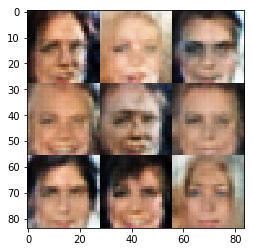

Step: 3610: Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6700
Step: 3620: Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6811
Step: 3630: Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7541
Step: 3640: Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7764
Step: 3650: Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7713
Step: 3660: Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7497
Step: 3670: Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7593
Step: 3680: Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7965
Step: 3690: Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7201
Step: 3700: Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7596
Tensor("generator_37/Shape:0", shape=(4,), dtype=int32)


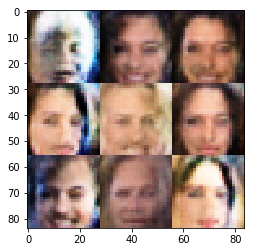

Step: 3710: Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8140
Step: 3720: Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8254
Step: 3730: Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7392
Step: 3740: Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7980
Step: 3750: Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7037
Step: 3760: Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7097
Step: 3770: Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7222
Step: 3780: Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7403
Step: 3790: Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7068
Step: 3800: Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8187
Tensor("generator_38/Shape:0", shape=(4,), dtype=int32)


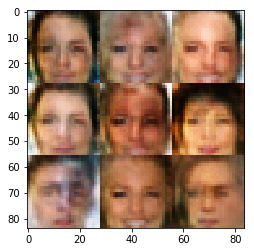

Step: 3810: Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7787
Step: 3820: Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7242
Step: 3830: Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7778
Step: 3840: Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6989
Step: 3850: Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7639
Step: 3860: Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8252
Step: 3870: Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7512
Step: 3880: Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7635
Step: 3890: Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7813
Step: 3900: Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7580
Tensor("generator_39/Shape:0", shape=(4,), dtype=int32)


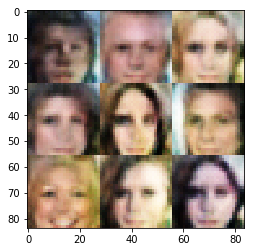

Step: 3910: Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.8059
Step: 3920: Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7605
Step: 3930: Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7785
Step: 3940: Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7359
Step: 3950: Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7852
Step: 3960: Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7628
Step: 3970: Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8071
Step: 3980: Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8265
Step: 3990: Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7765
Step: 4000: Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7162
Tensor("generator_40/Shape:0", shape=(4,), dtype=int32)


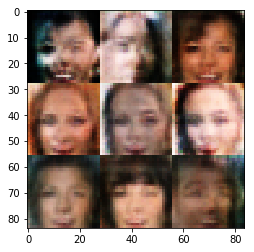

Step: 4010: Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7494
Step: 4020: Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7755
Step: 4030: Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8283
Step: 4040: Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8604
Step: 4050: Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7612
Step: 4060: Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7787
Step: 4070: Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8273
Step: 4080: Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7371
Step: 4090: Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7845
Step: 4100: Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7374
Tensor("generator_41/Shape:0", shape=(4,), dtype=int32)


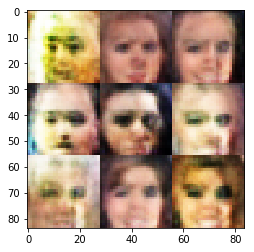

Step: 4110: Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7640
Step: 4120: Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6917
Step: 4130: Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7701
Step: 4140: Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7321
Step: 4150: Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7367
Step: 4160: Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7516
Step: 4170: Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7436
Step: 4180: Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7184
Step: 4190: Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7060
Step: 4200: Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7688
Tensor("generator_42/Shape:0", shape=(4,), dtype=int32)


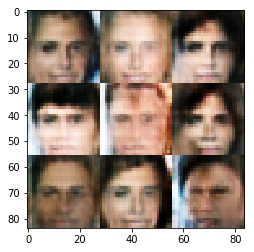

Step: 4210: Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8093
Step: 4220: Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7642
Step: 4230: Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8000
Step: 4240: Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7727
Step: 4250: Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8238
Step: 4260: Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7138
Step: 4270: Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7112
Step: 4280: Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8094
Step: 4290: Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7212
Step: 4300: Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7461
Tensor("generator_43/Shape:0", shape=(4,), dtype=int32)


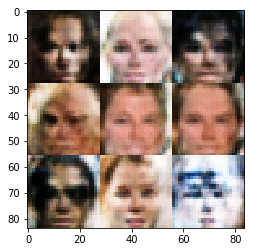

Step: 4310: Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7697
Step: 4320: Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7149
Step: 4330: Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7973
Step: 4340: Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7112
Step: 4350: Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7638
Step: 4360: Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7868
Step: 4370: Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7590
Step: 4380: Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8221
Step: 4390: Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7528
Step: 4400: Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7641
Tensor("generator_44/Shape:0", shape=(4,), dtype=int32)


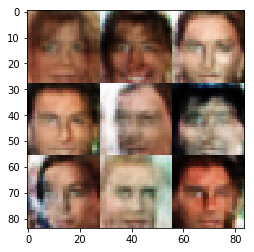

Step: 4410: Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8224
Step: 4420: Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7257
Step: 4430: Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7475
Step: 4440: Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7386
Step: 4450: Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7165
Step: 4460: Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7828
Step: 4470: Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6848
Step: 4480: Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7263
Step: 4490: Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7704
Step: 4500: Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7935
Tensor("generator_45/Shape:0", shape=(4,), dtype=int32)


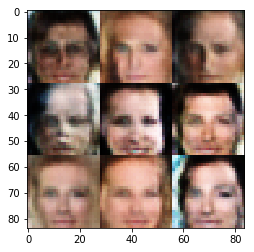

Step: 4510: Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7762
Step: 4520: Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8012
Step: 4530: Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7409
Step: 4540: Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6691
Step: 4550: Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7816
Step: 4560: Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7570
Step: 4570: Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7505
Step: 4580: Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7629
Step: 4590: Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7584
Step: 4600: Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7448
Tensor("generator_46/Shape:0", shape=(4,), dtype=int32)


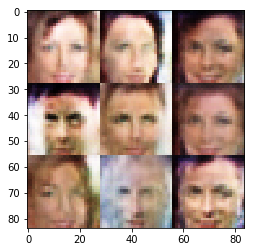

Step: 4610: Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6670
Step: 4620: Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7568
Step: 4630: Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7581
Step: 4640: Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7352
Step: 4650: Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8649
Step: 4660: Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7112
Step: 4670: Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6992
Step: 4680: Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7382
Step: 4690: Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7403
Step: 4700: Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7155
Tensor("generator_47/Shape:0", shape=(4,), dtype=int32)


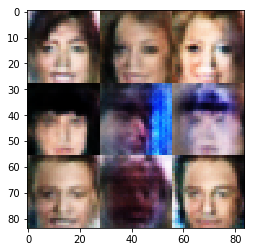

Step: 4710: Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7802
Step: 4720: Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7490
Step: 4730: Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7386
Step: 4740: Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7672
Step: 4750: Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7708
Step: 4760: Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7876
Step: 4770: Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7779
Step: 4780: Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7612
Step: 4790: Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8086
Step: 4800: Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7808
Tensor("generator_48/Shape:0", shape=(4,), dtype=int32)


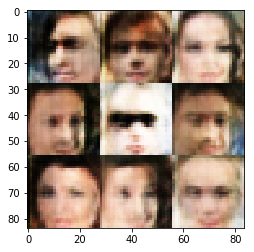

Step: 4810: Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6701
Step: 4820: Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7857
Step: 4830: Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7018
Step: 4840: Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7525
Step: 4850: Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7444
Step: 4860: Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8179
Step: 4870: Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7837
Step: 4880: Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7262
Step: 4890: Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7503
Step: 4900: Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7929
Tensor("generator_49/Shape:0", shape=(4,), dtype=int32)


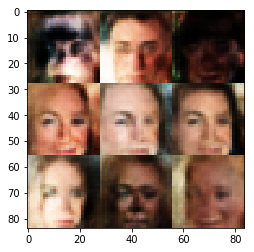

Step: 4910: Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7613
Step: 4920: Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7714
Step: 4930: Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7239
Step: 4940: Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7244
Step: 4950: Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7081
Step: 4960: Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7376
Step: 4970: Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7729
Step: 4980: Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7351
Step: 4990: Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7617
Step: 5000: Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7590
Tensor("generator_50/Shape:0", shape=(4,), dtype=int32)


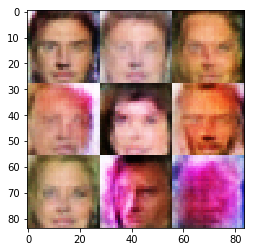

Step: 5010: Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8009
Step: 5020: Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7814
Step: 5030: Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7747
Step: 5040: Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7846
Step: 5050: Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7778
Step: 5060: Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7568
Step: 5070: Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8221
Step: 5080: Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8012
Step: 5090: Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7508
Step: 5100: Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7677
Tensor("generator_51/Shape:0", shape=(4,), dtype=int32)


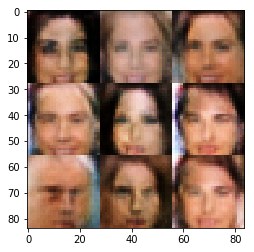

Step: 5110: Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7673
Step: 5120: Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8294
Step: 5130: Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8337
Step: 5140: Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7111
Step: 5150: Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7535
Step: 5160: Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7748
Step: 5170: Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7597
Step: 5180: Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8072
Step: 5190: Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7788
Step: 5200: Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7143
Tensor("generator_52/Shape:0", shape=(4,), dtype=int32)


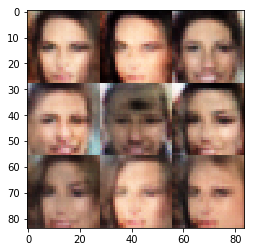

Step: 5210: Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6863
Step: 5220: Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6837
Step: 5230: Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8045
Step: 5240: Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7246
Step: 5250: Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7815
Step: 5260: Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8153
Step: 5270: Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7443
Step: 5280: Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7631
Step: 5290: Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8072
Step: 5300: Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7271
Tensor("generator_53/Shape:0", shape=(4,), dtype=int32)


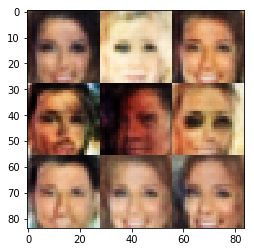

Step: 5310: Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7279
Step: 5320: Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8360
Step: 5330: Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7650
Step: 5340: Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7452
Step: 5350: Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7099
Step: 5360: Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7351
Step: 5370: Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7636
Step: 5380: Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7577
Step: 5390: Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7973
Step: 5400: Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7342
Tensor("generator_54/Shape:0", shape=(4,), dtype=int32)


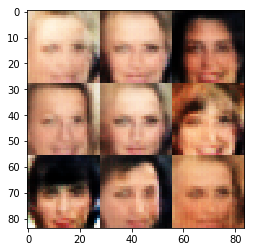

Step: 5410: Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8225
Step: 5420: Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7276
Step: 5430: Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7879
Step: 5440: Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7010
Step: 5450: Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7602
Step: 5460: Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7625
Step: 5470: Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8531
Step: 5480: Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8394
Step: 5490: Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7533
Step: 5500: Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7511
Tensor("generator_55/Shape:0", shape=(4,), dtype=int32)


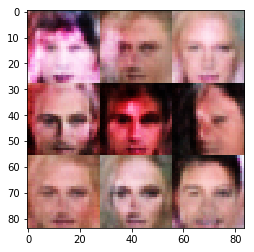

Step: 5510: Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7340
Step: 5520: Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8349
Step: 5530: Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7214
Step: 5540: Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7658
Step: 5550: Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7321
Step: 5560: Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8294
Step: 5570: Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6847
Step: 5580: Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7168
Step: 5590: Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7407
Step: 5600: Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7859
Tensor("generator_56/Shape:0", shape=(4,), dtype=int32)


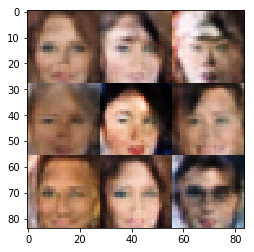

Step: 5610: Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7514
Step: 5620: Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7382
Step: 5630: Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7158
Step: 5640: Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7622
Step: 5650: Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7975
Step: 5660: Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8593
Step: 5670: Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7291
Step: 5680: Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8126
Step: 5690: Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7633
Step: 5700: Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7643
Tensor("generator_57/Shape:0", shape=(4,), dtype=int32)


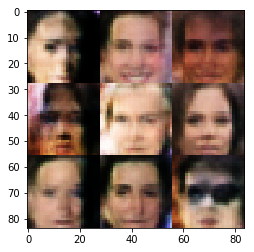

Step: 5710: Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8032
Step: 5720: Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7889
Step: 5730: Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7778
Step: 5740: Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7941
Step: 5750: Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7640
Step: 5760: Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7625
Step: 5770: Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7726
Step: 5780: Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8012
Step: 5790: Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6405
Step: 5800: Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7708
Tensor("generator_58/Shape:0", shape=(4,), dtype=int32)


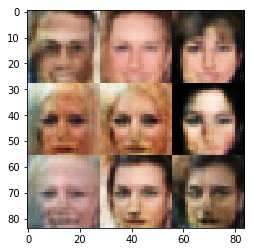

Step: 5810: Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7683
Step: 5820: Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7850
Step: 5830: Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7352
Step: 5840: Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7609
Step: 5850: Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7800
Step: 5860: Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7147
Step: 5870: Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8464
Step: 5880: Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7402
Step: 5890: Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6941
Step: 5900: Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7792
Tensor("generator_59/Shape:0", shape=(4,), dtype=int32)


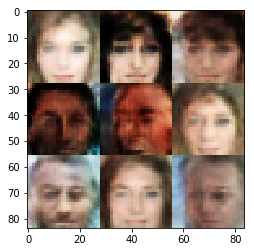

Step: 5910: Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7499
Step: 5920: Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7031
Step: 5930: Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7233
Step: 5940: Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7132
Step: 5950: Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7822
Step: 5960: Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6907
Step: 5970: Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8261
Step: 5980: Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7415
Step: 5990: Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8324
Step: 6000: Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8248
Tensor("generator_60/Shape:0", shape=(4,), dtype=int32)


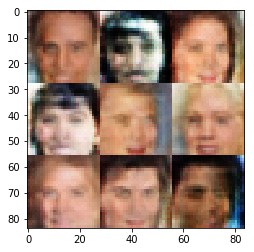

Step: 6010: Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7640
Step: 6020: Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7508
Step: 6030: Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8007
Step: 6040: Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7960
Step: 6050: Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7411
Step: 6060: Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7432
Step: 6070: Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7705
Step: 6080: Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8065
Step: 6090: Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6753
Step: 6100: Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7111
Tensor("generator_61/Shape:0", shape=(4,), dtype=int32)


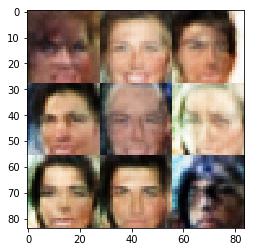

Step: 6110: Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7171
Step: 6120: Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7846
Step: 6130: Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7719
Step: 6140: Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7780
Step: 6150: Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7606
Step: 6160: Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7859
Step: 6170: Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6852
Step: 6180: Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7510
Step: 6190: Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7184
Step: 6200: Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7242
Tensor("generator_62/Shape:0", shape=(4,), dtype=int32)


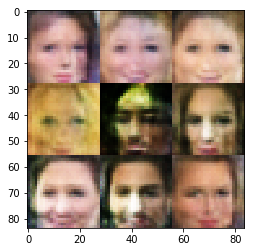

Step: 6210: Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8265
Step: 6220: Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8112
Step: 6230: Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6849
Step: 6240: Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7831
Step: 6250: Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7573
Step: 6260: Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7391
Step: 6270: Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6821
Step: 6280: Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8750
Step: 6290: Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8128
Step: 6300: Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7090
Tensor("generator_63/Shape:0", shape=(4,), dtype=int32)


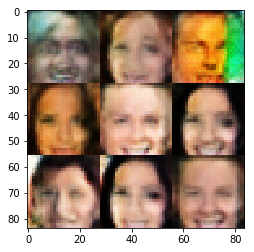

Step: 6310: Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7567
Step: 6320: Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7688
Step: 6330: Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7742
Finished the training


In [45]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Tensor("generator/Shape:0", shape=(4,), dtype=int32)
Starting the training
Step: 10: Epoch 1/1... Discriminator Loss: 3.4104... Generator Loss: 0.2132
Step: 20: Epoch 1/1... Discriminator Loss: 2.3293... Generator Loss: 0.3851
Step: 30: Epoch 1/1... Discriminator Loss: 2.5466... Generator Loss: 0.3038
Step: 40: Epoch 1/1... Discriminator Loss: 2.7356... Generator Loss: 0.2292
Step: 50: Epoch 1/1... Discriminator Loss: 1.8110... Generator Loss: 0.7262
Step: 60: Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.8948
Step: 70: Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 2.1489
Step: 80: Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.2164
Step: 90: Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.9573
Step: 100: Epoch 1/1... Discriminator Loss: 1.7818... Generator Loss: 0.6445
Tensor("generator_1/Shape:0", shape=(4,), dtype=int32)


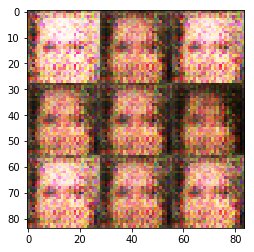

Step: 110: Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.0857
Step: 120: Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9956
Step: 130: Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7958
Step: 140: Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.5319
Step: 150: Epoch 1/1... Discriminator Loss: 1.9040... Generator Loss: 0.4787
Step: 160: Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 1.2791
Step: 170: Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5449
Step: 180: Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7762
Step: 190: Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.0722
Step: 200: Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.9511
Tensor("generator_2/Shape:0", shape=(4,), dtype=int32)


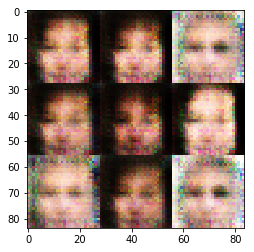

Step: 210: Epoch 1/1... Discriminator Loss: 1.7387... Generator Loss: 0.8088
Step: 220: Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7486
Step: 230: Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.9013
Step: 240: Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.5101
Step: 250: Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7334
Step: 260: Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6255
Step: 270: Epoch 1/1... Discriminator Loss: 1.7233... Generator Loss: 1.1697
Step: 280: Epoch 1/1... Discriminator Loss: 1.8188... Generator Loss: 0.8201
Step: 290: Epoch 1/1... Discriminator Loss: 1.7241... Generator Loss: 0.5239
Step: 300: Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9624
Tensor("generator_3/Shape:0", shape=(4,), dtype=int32)


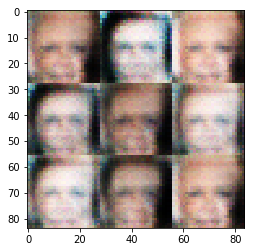

Step: 310: Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.7976
Step: 320: Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7064
Step: 330: Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.7190
Step: 340: Epoch 1/1... Discriminator Loss: 1.7345... Generator Loss: 0.8124
Step: 350: Epoch 1/1... Discriminator Loss: 1.8362... Generator Loss: 0.7308
Step: 360: Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7495
Step: 370: Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0676
Step: 380: Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.6345
Step: 390: Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8561
Step: 400: Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7858
Tensor("generator_4/Shape:0", shape=(4,), dtype=int32)


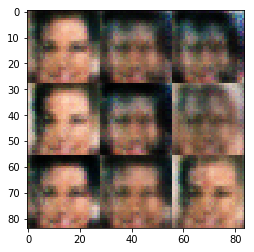

Step: 410: Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8600
Step: 420: Epoch 1/1... Discriminator Loss: 1.9124... Generator Loss: 0.6464
Step: 430: Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.7870
Step: 440: Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.8672
Step: 450: Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8151
Step: 460: Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8114
Step: 470: Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.6339
Step: 480: Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7703
Step: 490: Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.7517
Step: 500: Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8730
Tensor("generator_5/Shape:0", shape=(4,), dtype=int32)


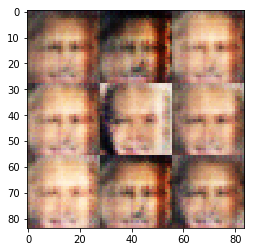

Step: 510: Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.6092
Step: 520: Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8411
Step: 530: Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7349
Step: 540: Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.6928
Step: 550: Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.7273
Step: 560: Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7717
Step: 570: Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.0901
Step: 580: Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.9752
Step: 590: Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8878
Step: 600: Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.9952
Tensor("generator_6/Shape:0", shape=(4,), dtype=int32)


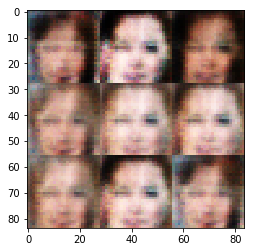

Step: 610: Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8712
Step: 620: Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6814
Step: 630: Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8653
Step: 640: Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.0287
Step: 650: Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7047
Step: 660: Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.9293
Step: 670: Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.6992
Step: 680: Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.7221
Step: 690: Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.1236
Step: 700: Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7888
Tensor("generator_7/Shape:0", shape=(4,), dtype=int32)


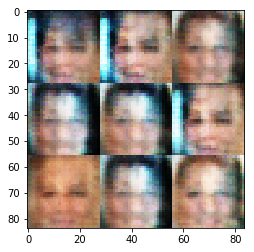

Step: 710: Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8329
Step: 720: Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.9806
Step: 730: Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.6016
Step: 740: Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.1055
Step: 750: Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6908
Step: 760: Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.6632
Step: 770: Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6480
Step: 780: Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7355
Step: 790: Epoch 1/1... Discriminator Loss: 1.7875... Generator Loss: 0.5878
Step: 800: Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8162
Tensor("generator_8/Shape:0", shape=(4,), dtype=int32)


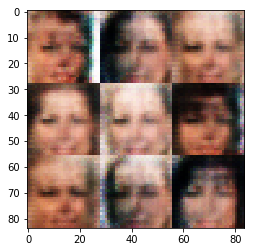

Step: 810: Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7644
Step: 820: Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.7758
Step: 830: Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7574
Step: 840: Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7372
Step: 850: Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.9303
Step: 860: Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.7472
Step: 870: Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9140
Step: 880: Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7878
Step: 890: Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.8055
Step: 900: Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6857
Tensor("generator_9/Shape:0", shape=(4,), dtype=int32)


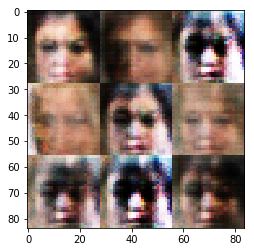

Step: 910: Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8146
Step: 920: Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.7004
Step: 930: Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7211
Step: 940: Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8768
Step: 950: Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7578
Step: 960: Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8151
Step: 970: Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7393
Step: 980: Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7730
Step: 990: Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7189
Step: 1000: Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7882
Tensor("generator_10/Shape:0", shape=(4,), dtype=int32)


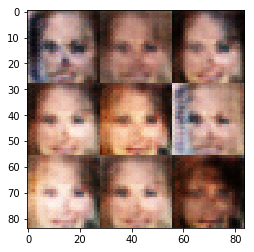

Step: 1010: Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.9557
Step: 1020: Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7930
Step: 1030: Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8287
Step: 1040: Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7033
Step: 1050: Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7406
Step: 1060: Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7698
Step: 1070: Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.7177
Step: 1080: Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.9125
Step: 1090: Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.9476
Step: 1100: Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8944
Tensor("generator_11/Shape:0", shape=(4,), dtype=int32)


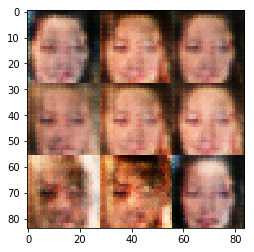

Step: 1110: Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7344
Step: 1120: Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7823
Step: 1130: Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7314
Step: 1140: Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7861
Step: 1150: Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6996
Step: 1160: Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8259
Step: 1170: Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7401
Step: 1180: Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7544
Step: 1190: Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.7215
Step: 1200: Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.8672
Tensor("generator_12/Shape:0", shape=(4,), dtype=int32)


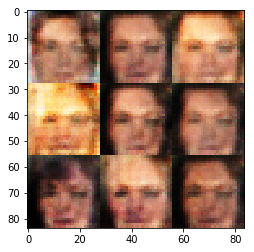

Step: 1210: Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6495
Step: 1220: Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7076
Step: 1230: Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6565
Step: 1240: Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7333
Step: 1250: Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8771
Step: 1260: Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7051
Step: 1270: Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6506
Step: 1280: Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.8557
Step: 1290: Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7639
Step: 1300: Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 0.7483
Tensor("generator_13/Shape:0", shape=(4,), dtype=int32)


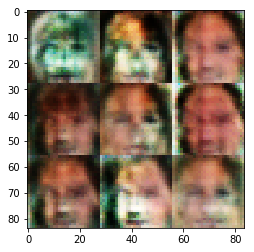

Step: 1310: Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7746
Step: 1320: Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.6132
Step: 1330: Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.6435
Step: 1340: Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7741
Step: 1350: Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7257
Step: 1360: Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.6704
Step: 1370: Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8075
Step: 1380: Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6967
Step: 1390: Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8348
Step: 1400: Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7409
Tensor("generator_14/Shape:0", shape=(4,), dtype=int32)


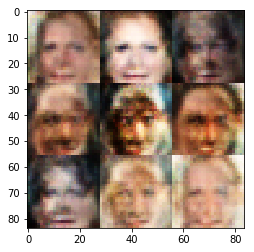

Step: 1410: Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7962
Step: 1420: Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7320
Step: 1430: Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.6812
Step: 1440: Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7649
Step: 1450: Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.6984
Step: 1460: Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.6363
Step: 1470: Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6754
Step: 1480: Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8074
Step: 1490: Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7323
Step: 1500: Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6609
Tensor("generator_15/Shape:0", shape=(4,), dtype=int32)


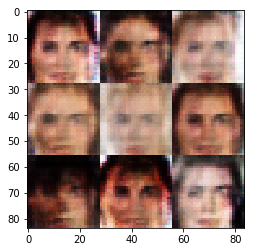

Step: 1510: Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8309
Step: 1520: Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8200
Step: 1530: Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7207
Step: 1540: Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7207
Step: 1550: Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8390
Step: 1560: Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8092
Step: 1570: Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8064
Step: 1580: Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8212
Step: 1590: Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7290
Step: 1600: Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6894
Tensor("generator_16/Shape:0", shape=(4,), dtype=int32)


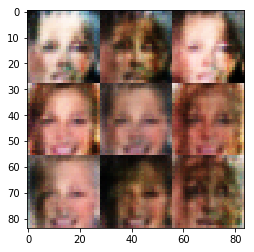

Step: 1610: Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6960
Step: 1620: Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7898
Step: 1630: Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7254
Step: 1640: Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7552
Step: 1650: Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7335
Step: 1660: Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7588
Step: 1670: Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6964
Step: 1680: Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.6215
Step: 1690: Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.7470
Step: 1700: Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.7165
Tensor("generator_17/Shape:0", shape=(4,), dtype=int32)


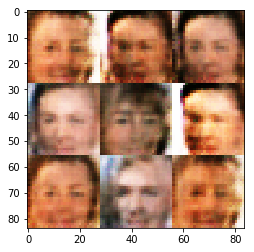

Step: 1710: Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7915
Step: 1720: Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6908
Step: 1730: Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7876
Step: 1740: Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8042
Step: 1750: Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6796
Step: 1760: Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8377
Step: 1770: Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.6816
Step: 1780: Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7553
Step: 1790: Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7321
Step: 1800: Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6738
Tensor("generator_18/Shape:0", shape=(4,), dtype=int32)


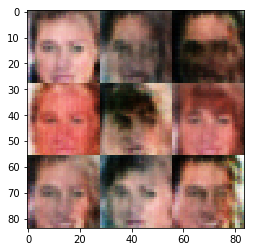

Step: 1810: Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.6737
Step: 1820: Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.7244
Step: 1830: Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7869
Step: 1840: Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.7054
Step: 1850: Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7329
Step: 1860: Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8038
Step: 1870: Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6759
Step: 1880: Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7748
Step: 1890: Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.7513
Step: 1900: Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7247
Tensor("generator_19/Shape:0", shape=(4,), dtype=int32)


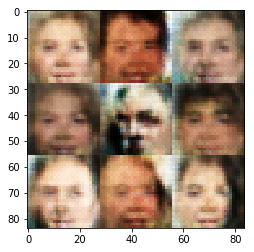

Step: 1910: Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6782
Step: 1920: Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7553
Step: 1930: Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7482
Step: 1940: Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7529
Step: 1950: Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7183
Step: 1960: Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7823
Step: 1970: Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7476
Step: 1980: Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.6924
Step: 1990: Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7453
Step: 2000: Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7409
Tensor("generator_20/Shape:0", shape=(4,), dtype=int32)


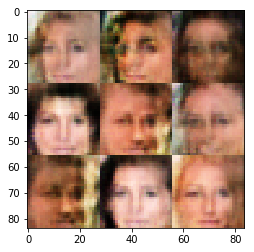

Step: 2010: Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7492
Step: 2020: Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7534
Step: 2030: Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8608
Step: 2040: Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.7496
Step: 2050: Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7723
Step: 2060: Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7249
Step: 2070: Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6850
Step: 2080: Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7545
Step: 2090: Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7766
Step: 2100: Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7630
Tensor("generator_21/Shape:0", shape=(4,), dtype=int32)


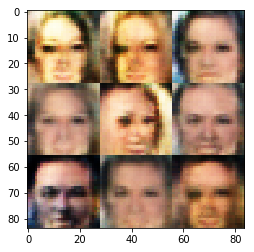

Step: 2110: Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7135
Step: 2120: Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7463
Step: 2130: Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6913
Step: 2140: Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7213
Step: 2150: Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7881
Step: 2160: Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6607
Step: 2170: Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7318
Step: 2180: Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7159
Step: 2190: Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8287
Step: 2200: Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7875
Tensor("generator_22/Shape:0", shape=(4,), dtype=int32)


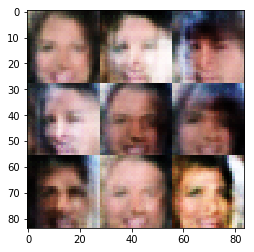

Step: 2210: Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8052
Step: 2220: Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6902
Step: 2230: Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7483
Step: 2240: Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.8380
Step: 2250: Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7193
Step: 2260: Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7763
Step: 2270: Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7020
Step: 2280: Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.6917
Step: 2290: Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7596
Step: 2300: Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7855
Tensor("generator_23/Shape:0", shape=(4,), dtype=int32)


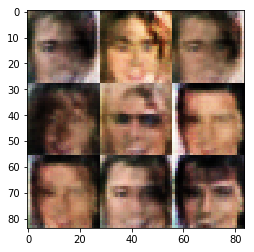

Step: 2310: Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7627
Step: 2320: Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7621
Step: 2330: Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7727
Step: 2340: Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6889
Step: 2350: Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7016
Step: 2360: Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7419
Step: 2370: Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7308
Step: 2380: Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7384
Step: 2390: Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8363
Step: 2400: Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7493
Tensor("generator_24/Shape:0", shape=(4,), dtype=int32)


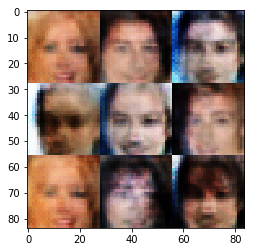

Step: 2410: Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7089
Step: 2420: Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8525
Step: 2430: Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7993
Step: 2440: Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7913
Step: 2450: Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7189
Step: 2460: Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8085
Step: 2470: Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7948
Step: 2480: Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7795
Step: 2490: Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7867
Step: 2500: Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6945
Tensor("generator_25/Shape:0", shape=(4,), dtype=int32)


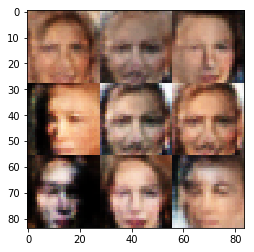

Step: 2510: Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7960
Step: 2520: Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7573
Step: 2530: Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7530
Step: 2540: Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7970
Step: 2550: Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7316
Step: 2560: Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7082
Step: 2570: Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7467
Step: 2580: Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7391
Step: 2590: Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7642
Step: 2600: Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7549
Tensor("generator_26/Shape:0", shape=(4,), dtype=int32)


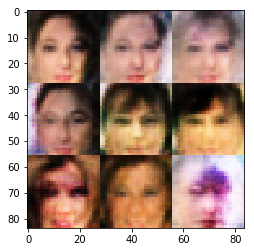

Step: 2610: Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7467
Step: 2620: Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7632
Step: 2630: Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7381
Step: 2640: Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.6812
Step: 2650: Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7203
Step: 2660: Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7581
Step: 2670: Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7208
Step: 2680: Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7750
Step: 2690: Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7996
Step: 2700: Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6828
Tensor("generator_27/Shape:0", shape=(4,), dtype=int32)


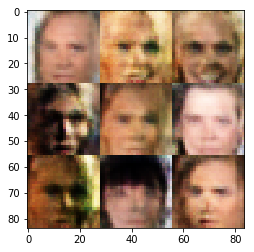

Step: 2710: Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7891
Step: 2720: Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7021
Step: 2730: Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7531
Step: 2740: Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7394
Step: 2750: Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7349
Step: 2760: Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8010
Step: 2770: Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7009
Step: 2780: Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7227
Step: 2790: Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.6863
Step: 2800: Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8005
Tensor("generator_28/Shape:0", shape=(4,), dtype=int32)


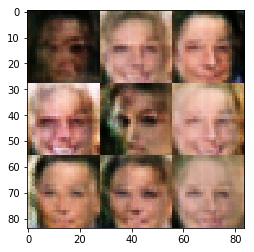

Step: 2810: Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7903
Step: 2820: Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7549
Step: 2830: Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7469
Step: 2840: Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7327
Step: 2850: Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8210
Step: 2860: Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7589
Step: 2870: Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7764
Step: 2880: Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7680
Step: 2890: Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7833
Step: 2900: Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7064
Tensor("generator_29/Shape:0", shape=(4,), dtype=int32)


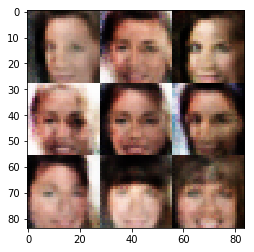

Step: 2910: Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7694
Step: 2920: Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7482
Step: 2930: Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6671
Step: 2940: Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7103
Step: 2950: Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7844
Step: 2960: Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7617
Step: 2970: Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.7224
Step: 2980: Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7858
Step: 2990: Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8393
Step: 3000: Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7777
Tensor("generator_30/Shape:0", shape=(4,), dtype=int32)


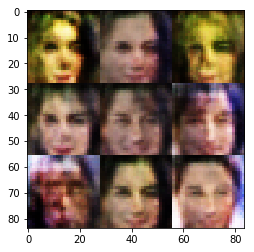

Step: 3010: Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6928
Step: 3020: Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.6530
Step: 3030: Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7403
Step: 3040: Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7095
Step: 3050: Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7382
Step: 3060: Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6681
Step: 3070: Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8745
Step: 3080: Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7327
Step: 3090: Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7704
Step: 3100: Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7831
Tensor("generator_31/Shape:0", shape=(4,), dtype=int32)


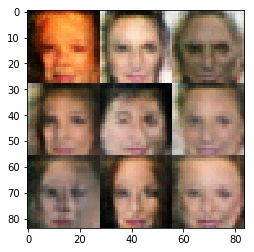

Step: 3110: Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7027
Step: 3120: Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8934
Step: 3130: Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7871
Step: 3140: Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.7151
Step: 3150: Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7401
Step: 3160: Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7433
Step: 3170: Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7134
Step: 3180: Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7792
Step: 3190: Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7793
Step: 3200: Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7757
Tensor("generator_32/Shape:0", shape=(4,), dtype=int32)


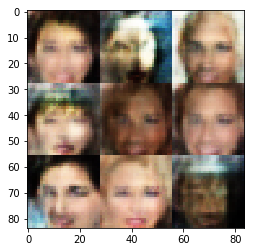

Step: 3210: Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7575
Step: 3220: Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7669
Step: 3230: Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7849
Step: 3240: Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7929
Step: 3250: Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7272
Step: 3260: Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7604
Step: 3270: Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6907
Step: 3280: Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7896
Step: 3290: Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7273
Step: 3300: Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7280
Tensor("generator_33/Shape:0", shape=(4,), dtype=int32)


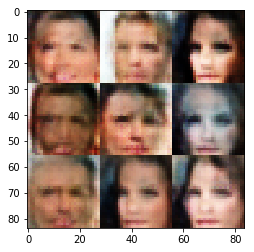

Step: 3310: Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7681
Step: 3320: Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6784
Step: 3330: Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7447
Step: 3340: Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7430
Step: 3350: Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7496
Step: 3360: Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7272
Step: 3370: Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7643
Step: 3380: Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7423
Step: 3390: Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7701
Step: 3400: Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7503
Tensor("generator_34/Shape:0", shape=(4,), dtype=int32)


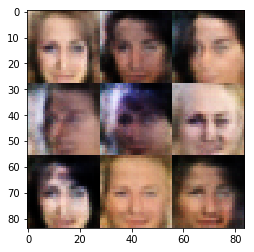

Step: 3410: Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7768
Step: 3420: Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7682
Step: 3430: Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7500
Step: 3440: Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7182
Step: 3450: Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7470
Step: 3460: Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7697
Step: 3470: Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7715
Step: 3480: Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7595
Step: 3490: Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7769
Step: 3500: Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7649
Tensor("generator_35/Shape:0", shape=(4,), dtype=int32)


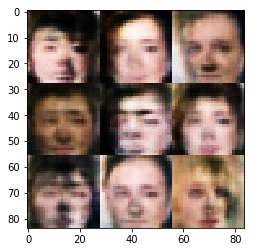

Step: 3510: Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7910
Step: 3520: Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7469
Step: 3530: Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7976
Step: 3540: Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7654
Step: 3550: Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8058
Step: 3560: Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7777
Step: 3570: Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8514
Step: 3580: Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7534
Step: 3590: Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7684
Step: 3600: Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7670
Tensor("generator_36/Shape:0", shape=(4,), dtype=int32)


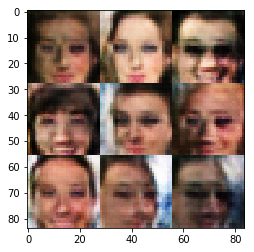

Step: 3610: Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7576
Step: 3620: Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7559
Step: 3630: Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7596
Step: 3640: Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7843
Step: 3650: Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8095
Step: 3660: Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7044
Step: 3670: Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7598
Step: 3680: Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7074
Step: 3690: Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7713
Step: 3700: Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7967
Tensor("generator_37/Shape:0", shape=(4,), dtype=int32)


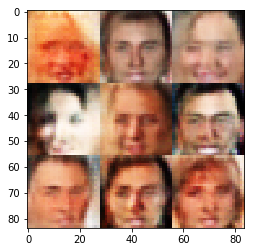

Step: 3710: Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7630
Step: 3720: Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7517
Step: 3730: Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7028
Step: 3740: Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7060
Step: 3750: Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7286
Step: 3760: Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7041
Step: 3770: Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7390
Step: 3780: Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7320
Step: 3790: Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8185
Step: 3800: Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7324
Tensor("generator_38/Shape:0", shape=(4,), dtype=int32)


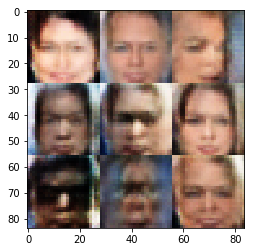

Step: 3810: Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7460
Step: 3820: Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7628
Step: 3830: Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7472
Step: 3840: Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7394
Step: 3850: Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7539
Step: 3860: Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8474
Step: 3870: Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6916
Step: 3880: Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7798
Step: 3890: Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7692
Step: 3900: Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7426
Tensor("generator_39/Shape:0", shape=(4,), dtype=int32)


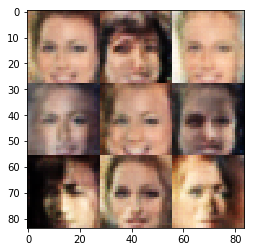

Step: 3910: Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8193
Step: 3920: Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8251
Step: 3930: Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7002
Step: 3940: Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7478
Step: 3950: Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7764
Step: 3960: Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7863
Step: 3970: Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7862
Step: 3980: Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8115
Step: 3990: Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7567
Step: 4000: Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7897
Tensor("generator_40/Shape:0", shape=(4,), dtype=int32)


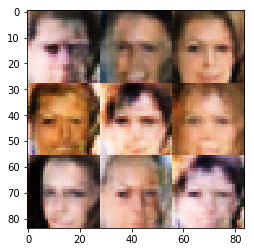

Step: 4010: Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8088
Step: 4020: Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7390
Step: 4030: Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7578
Step: 4040: Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6951
Step: 4050: Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8108
Step: 4060: Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7964
Step: 4070: Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7543
Step: 4080: Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7938
Step: 4090: Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7574
Step: 4100: Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7312
Tensor("generator_41/Shape:0", shape=(4,), dtype=int32)


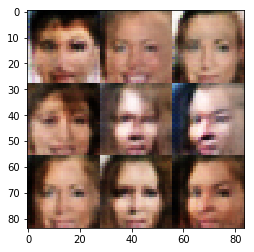

Step: 4110: Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7462
Step: 4120: Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7405
Step: 4130: Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7482
Step: 4140: Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8896
Step: 4150: Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7387
Step: 4160: Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7263
Step: 4170: Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6676
Step: 4180: Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7533
Step: 4190: Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8139
Step: 4200: Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8076
Tensor("generator_42/Shape:0", shape=(4,), dtype=int32)


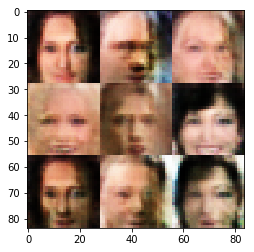

Step: 4210: Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7849
Step: 4220: Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7125
Step: 4230: Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7373
Step: 4240: Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6839
Step: 4250: Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8698
Step: 4260: Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8176
Step: 4270: Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7099
Step: 4280: Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7942
Step: 4290: Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7368
Step: 4300: Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7709
Tensor("generator_43/Shape:0", shape=(4,), dtype=int32)


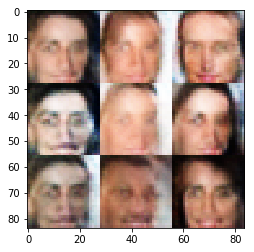

Step: 4310: Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7372
Step: 4320: Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7251
Step: 4330: Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7242
Step: 4340: Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6948
Step: 4350: Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7637
Step: 4360: Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7963
Step: 4370: Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7192
Step: 4380: Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8312
Step: 4390: Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7418
Step: 4400: Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7668
Tensor("generator_44/Shape:0", shape=(4,), dtype=int32)


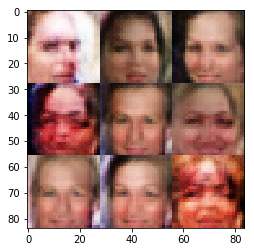

Step: 4410: Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6961
Step: 4420: Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7650
Step: 4430: Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7853
Step: 4440: Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7010
Step: 4450: Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7889
Step: 4460: Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7692
Step: 4470: Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7204
Step: 4480: Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7835
Step: 4490: Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7824
Step: 4500: Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7600
Tensor("generator_45/Shape:0", shape=(4,), dtype=int32)


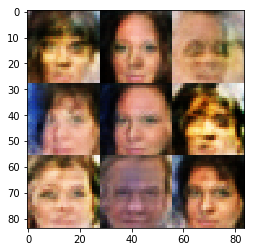

Step: 4510: Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7512
Step: 4520: Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7437
Step: 4530: Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7405
Step: 4540: Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7580
Step: 4550: Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8150
Step: 4560: Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7661
Step: 4570: Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8777
Step: 4580: Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7721
Step: 4590: Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8062
Step: 4600: Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7386
Tensor("generator_46/Shape:0", shape=(4,), dtype=int32)


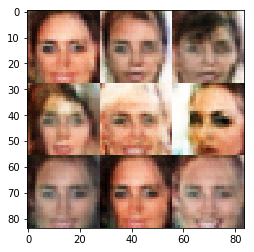

Step: 4610: Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7293
Step: 4620: Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8018
Step: 4630: Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7468
Step: 4640: Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8145
Step: 4650: Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7492
Step: 4660: Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7577
Step: 4670: Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7638
Step: 4680: Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7128
Step: 4690: Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7831
Step: 4700: Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7600
Tensor("generator_47/Shape:0", shape=(4,), dtype=int32)


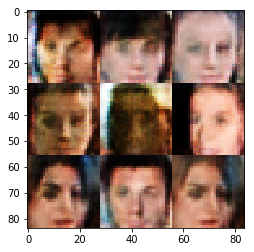

Step: 4710: Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7331
Step: 4720: Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7290
Step: 4730: Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7958
Step: 4740: Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8090
Step: 4750: Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8678
Step: 4760: Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7606
Step: 4770: Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8102
Step: 4780: Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8161
Step: 4790: Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7506
Step: 4800: Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8260
Tensor("generator_48/Shape:0", shape=(4,), dtype=int32)


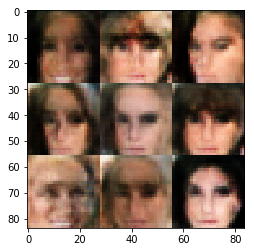

Step: 4810: Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7421
Step: 4820: Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7459
Step: 4830: Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7154
Step: 4840: Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7125
Step: 4850: Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7880
Step: 4860: Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7552
Step: 4870: Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7497
Step: 4880: Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7872
Step: 4890: Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8159
Step: 4900: Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7605
Tensor("generator_49/Shape:0", shape=(4,), dtype=int32)


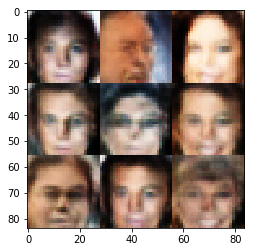

Step: 4910: Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7729
Step: 4920: Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7321
Step: 4930: Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7080
Step: 4940: Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7239
Step: 4950: Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6917
Step: 4960: Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7398
Step: 4970: Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8033
Step: 4980: Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6947
Step: 4990: Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7872
Step: 5000: Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8554
Tensor("generator_50/Shape:0", shape=(4,), dtype=int32)


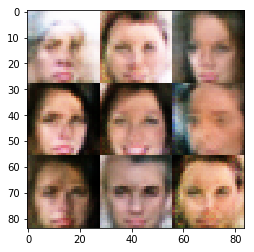

Step: 5010: Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7547
Step: 5020: Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7873
Step: 5030: Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7513
Step: 5040: Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7702
Step: 5050: Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7454
Step: 5060: Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7784
Step: 5070: Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7631
Step: 5080: Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8149
Step: 5090: Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8207
Step: 5100: Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8500
Tensor("generator_51/Shape:0", shape=(4,), dtype=int32)


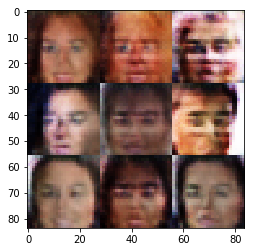

Step: 5110: Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6722
Step: 5120: Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8005
Step: 5130: Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8309
Step: 5140: Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6975
Step: 5150: Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7725
Step: 5160: Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7806
Step: 5170: Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7011
Step: 5180: Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8247
Step: 5190: Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8251
Step: 5200: Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6679
Tensor("generator_52/Shape:0", shape=(4,), dtype=int32)


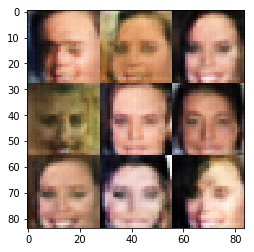

Step: 5210: Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7565
Step: 5220: Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7763
Step: 5230: Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7898
Step: 5240: Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6708
Step: 5250: Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7655
Step: 5260: Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7499
Step: 5270: Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8297
Step: 5280: Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7479
Step: 5290: Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7397
Step: 5300: Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7504
Tensor("generator_53/Shape:0", shape=(4,), dtype=int32)


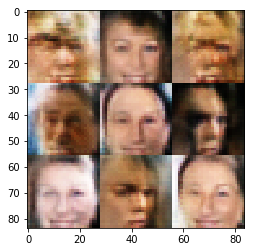

Step: 5310: Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7053
Step: 5320: Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8238
Step: 5330: Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7751
Step: 5340: Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.8009
Step: 5350: Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7178
Step: 5360: Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7173
Step: 5370: Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7729
Step: 5380: Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7880
Step: 5390: Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8231
Step: 5400: Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7628
Tensor("generator_54/Shape:0", shape=(4,), dtype=int32)


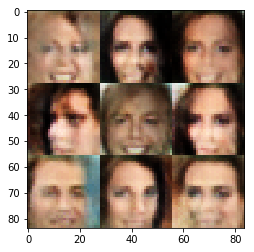

Step: 5410: Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7856
Step: 5420: Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7485
Step: 5430: Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7636
Step: 5440: Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7227
Step: 5450: Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8822
Step: 5460: Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8176
Step: 5470: Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8273
Step: 5480: Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8149
Step: 5490: Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7342
Step: 5500: Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7451
Tensor("generator_55/Shape:0", shape=(4,), dtype=int32)


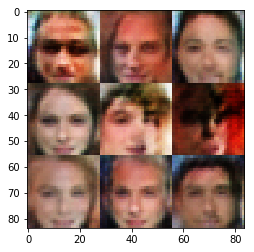

Step: 5510: Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7762
Step: 5520: Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8001
Step: 5530: Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8371
Step: 5540: Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7524
Step: 5550: Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7929
Step: 5560: Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8079
Step: 5570: Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7672
Step: 5580: Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7455
Step: 5590: Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7049
Step: 5600: Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7761
Tensor("generator_56/Shape:0", shape=(4,), dtype=int32)


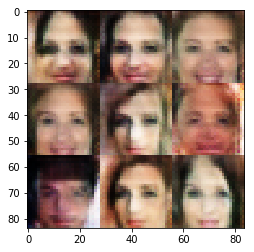

Step: 5610: Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7674
Step: 5620: Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7514
Step: 5630: Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7623
Step: 5640: Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7432
Step: 5650: Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8446
Step: 5660: Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8263
Step: 5670: Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7285
Step: 5680: Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7843
Step: 5690: Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7363
Step: 5700: Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8073
Tensor("generator_57/Shape:0", shape=(4,), dtype=int32)


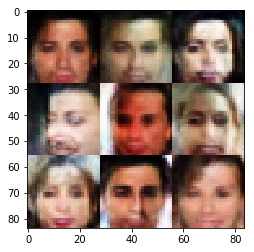

Step: 5710: Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7822
Step: 5720: Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.7567
Step: 5730: Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7268
Step: 5740: Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7684
Step: 5750: Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8191
Step: 5760: Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7616
Step: 5770: Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7742
Step: 5780: Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7884
Step: 5790: Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7744
Step: 5800: Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7186
Tensor("generator_58/Shape:0", shape=(4,), dtype=int32)


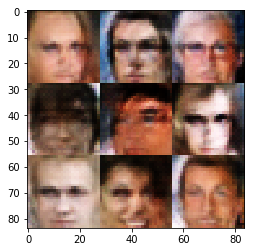

Step: 5810: Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7797
Step: 5820: Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7379
Step: 5830: Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6676
Step: 5840: Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6802
Step: 5850: Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8061
Step: 5860: Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7471
Step: 5870: Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7038
Step: 5880: Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7791
Step: 5890: Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7951
Step: 5900: Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7063
Tensor("generator_59/Shape:0", shape=(4,), dtype=int32)


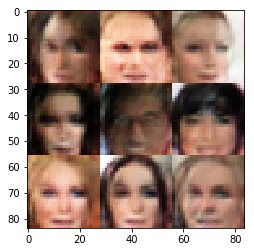

Step: 5910: Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7435
Step: 5920: Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7276
Step: 5930: Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7876
Step: 5940: Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7677
Step: 5950: Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7716
Step: 5960: Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7202
Step: 5970: Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8813
Step: 5980: Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8006
Step: 5990: Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7255
Step: 6000: Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8290
Tensor("generator_60/Shape:0", shape=(4,), dtype=int32)


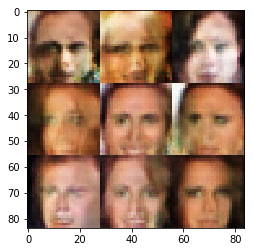

Step: 6010: Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7461
Step: 6020: Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6552
Step: 6030: Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7064
Step: 6040: Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7392
Step: 6050: Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7180
Step: 6060: Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7753
Step: 6070: Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8620
Step: 6080: Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8461
Step: 6090: Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7731
Step: 6100: Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7432
Tensor("generator_61/Shape:0", shape=(4,), dtype=int32)


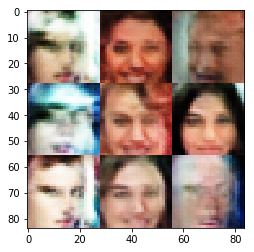

Step: 6110: Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6544
Step: 6120: Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7767
Step: 6130: Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7301
Step: 6140: Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6891
Step: 6150: Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6906
Step: 6160: Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7144
Step: 6170: Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7301
Step: 6180: Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7640
Step: 6190: Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6700
Step: 6200: Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7179
Tensor("generator_62/Shape:0", shape=(4,), dtype=int32)


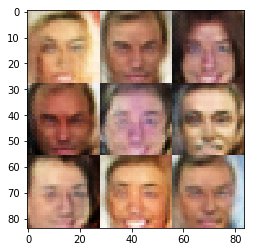

Step: 6210: Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7383
Step: 6220: Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7030
Step: 6230: Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7171
Step: 6240: Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8068
Step: 6250: Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9624
Step: 6260: Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8245
Step: 6270: Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6825
Step: 6280: Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8221
Step: 6290: Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7416
Step: 6300: Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8269
Tensor("generator_63/Shape:0", shape=(4,), dtype=int32)


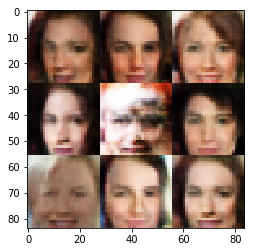

Step: 6310: Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7346
Step: 6320: Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8164
Step: 6330: Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7919
Finished the training


In [48]:
batch_size = 32
z_dim = 114
learning_rate = 0.0002
beta1 = 0.45

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.